<a href="https://colab.research.google.com/github/rll/deepul/blob/master/homeworks/hw3/hw3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting Started

## Overview
This semester, all homeworks will be conducted through Google Colab notebooks. All code for the homework assignment will be written and run in this notebook. Running in Colab will automatically provide a GPU, but you may also run this notebook locally by following [these instructions](https://research.google.com/colaboratory/local-runtimes.html) if you wish to use your own GPU.

You will save images in the notebooks to use and fill out a given LaTeX template which will be submitted to Gradescope, along with your notebook code.

## Using Colab
On the left-hand side, you can click the different icons to see a Table of Contents of the assignment, as well as local files accessible through the notebook.

Make sure to go to **Runtime -> Change runtime type** and select **GPU** as the hardware accelerator. This allows you to use a GPU. Run the cells below to get started on the assignment. Note that a session is open for a maximum of 12 hours, and using too much GPU compute may result in restricted access for a short period of time. Please start the homework early so you have ample time to work.

**If you loaded this notebook from clicking "Open in Colab" from github, you will need to save it to your own Google Drive to keep your work.**

## General Tips
In each homework problem, you will implement a GAN model and run it on a dataset. We provide the expected outputs to help as a sanity check.

Feel free to print whatever output (e.g. debugging code, training code, etc) you want, as the graded submission will be the submitted pdf with images.

After you complete the assignment, download all of the image outputted in the results/ folder and upload them to the figure folder in the given latex template.

Run the cells below to download and load up the starter code.

In [ ]:
# !if [ -d deepul ]; then rm -Rf deepul; fi
# !git clone https://github.com/rll/deepul.git
# !pip install ./deepul

# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
import warnings
from scipy.stats import norm
from tqdm import trange, tqdm_notebook

import deepul.pytorch_util as ptu
import deepul.utils as deepul_utils
import transformer
import vqvae
from deepul.hw3_helper import *

warnings.filterwarnings("ignore")

In [2]:
ptu.set_gpu_mode(True)

# Question 1: Warmup [20pt]

In this question, we will train different variants of GANs on an easy 1D dataset. 

Execute the cell below to visualize our datasets.

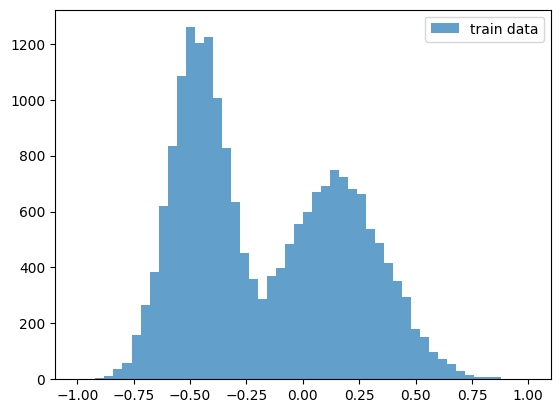

In [8]:
visualize_q1_dataset()

## Part 1(a)
In this part, we'll train our generator and discriminator via the original minimax GAN objective:
<insert GAN Objective here>
$$min_{G} max_{D} \mathbb{E}_{x \sim p_{data}} [\log D(x)] + \mathbb{E}_{z \sim p(z)}[\log (1-D(G(z)))]$$

Use an MLP for both your generator and your discriminator, and train until the generated distribution resembles the target distribution. 
* 3 layers
* 128 hidden dim
* LeakyReLU nonlinearities with negative_slope=0.2

### Solution

In [12]:
def train(
    generator,
    critic,
    c_loss_fn,
    g_loss_fn,
    train_loader,
    g_optimizer,
    c_optimizer,
    n_critic=1,
    g_scheduler=None,
    c_scheduler=None,
    weight_clipping=None,
):
    """
    generator:
    critic: discriminator in 1ab, general model otherwise
    loss_fn
    train_loader: instance of DataLoader class
    optimizer:
    ncritic: how many critic gradient steps to do for every generator step
    """
    g_losses, c_losses = [], []
    generator.train()
    critic.train()
    for i, x in enumerate(train_loader):
        x = x.to(ptu.device).float()
        c_optimizer.zero_grad()
        c_loss = c_loss_fn(generator, critic, x)
        c_loss.backward()
        c_optimizer.step()
        c_losses.append(c_loss.item())
        if weight_clipping is not None:
            for param in critic.parameters():
                param.data.clamp_(-weight_clipping, weight_clipping)

        if i % n_critic == 0:  # generator step
            g_optimizer.zero_grad()
            g_loss = g_loss_fn(generator, critic, x)
            g_loss.backward()
            g_optimizer.step()
            g_losses.append(g_loss.item())
            if g_scheduler is not None:
                g_scheduler.step()
            if c_scheduler is not None:
                c_scheduler.step()
    return dict(g_losses=g_losses, c_losses=c_losses)


def train_epochs(generator, critic, g_loss_fn, c_loss_fn, train_loader, train_args):
    epochs, lr = train_args["epochs"], train_args["lr"]
    if "optim_cls" in train_args:
        g_optimizer = train_args["optim_cls"](generator.parameters(), lr=lr)
        c_optimizer = train_args["optim_cls"](critic.parameters(), lr=lr)
    else:
        g_optimizer = optim.Adam(generator.parameters(), lr=lr, betas=(0, 0.9))
        c_optimizer = optim.Adam(critic.parameters(), lr=lr, betas=(0, 0.9))

    if train_args.get("lr_schedule", None) is not None:
        g_scheduler = optim.lr_scheduler.LambdaLR(
            g_optimizer, train_args["lr_schedule"]
        )
        c_scheduler = optim.lr_scheduler.LambdaLR(
            c_optimizer, train_args["lr_schedule"]
        )
    else:
        g_scheduler = None
        c_scheduler = None

    train_losses = dict()
    for epoch in tqdm_notebook(range(epochs), desc="Epoch", leave=False):
        if epoch == 1:
            epoch1_snapshot = get_training_snapshot(generator, critic)
        generator.train()
        critic.train()
        train_loss = train(
            generator,
            critic,
            c_loss_fn,
            g_loss_fn,
            train_loader,
            g_optimizer,
            c_optimizer,
            n_critic=train_args.get("n_critic", 0),
            g_scheduler=g_scheduler,
            c_scheduler=c_scheduler,
            weight_clipping=train_args.get("weight_clipping", None),
        )

        for k in train_loss.keys():
            if k not in train_losses:
                train_losses[k] = []
            train_losses[k].extend(train_loss[k])

    if train_args.get("q1", False):  # q1, return the snapshots
        final_snapshot = get_training_snapshot(generator, critic)
        return [train_losses, *epoch1_snapshot, *final_snapshot]
    else:
        return train_losses


def get_training_snapshot(generator, critic, n_samples=5000):
    generator.eval()
    critic.eval()
    xs = np.linspace(-1, 1, 1000)
    samples = ptu.get_numpy(generator.sample(n_samples))
    critic_output = ptu.get_numpy(critic(ptu.FloatTensor(xs).unsqueeze(1)))
    return samples, xs, critic_output

In [13]:
class MLP(nn.Module):
    def __init__(self, input_size, n_hidden, hidden_size, output_size):
        super().__init__()
        layers = []
        for _ in range(n_hidden):
            layers.append(nn.Linear(input_size, hidden_size))
            layers.append(nn.LeakyReLU(0.2))
            input_size = hidden_size
        layers.append(nn.Linear(hidden_size, output_size))
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)


class MLPGenerator(nn.Module):
    def __init__(self, latent_dim, n_hidden, hidden_size, data_dim):
        super().__init__()
        self.latent_dim = latent_dim
        self.mlp = MLP(latent_dim, n_hidden, hidden_size, data_dim)

    def forward(self, z):
        return torch.tanh(self.mlp(z))

    def sample(self, n):
        # n is the number of samples to return
        z = ptu.normal(ptu.zeros(n, self.latent_dim), ptu.ones(n, self.latent_dim))
        return self.forward(z)


class MLPDiscriminator(nn.Module):
    def __init__(self, latent_dim, n_hidden, hidden_size, data_dim):
        super().__init__()
        self.mlp = MLP(latent_dim, n_hidden, hidden_size, data_dim)

    def forward(self, z):
        return torch.sigmoid(self.mlp(z))

In [14]:
def q1_a(train_data):
    """
    train_data: An (20000, 1) numpy array of floats in [-1, 1]

    Returns
    - a (# of training iterations,) numpy array of discriminator losses evaluated every minibatch
    - a numpy array of size (5000,) of samples drawn from your model at epoch #1
    - a numpy array of size (1000,) linearly spaced from [-1, 1]; hint: np.linspace
    - a numpy array of size (1000,), corresponding to the discriminator output (after sigmoid)
        at each location in the previous array at epoch #1

    - a numpy array of size (5000,) of samples drawn from your model at the end of training
    - a numpy array of size (1000,) linearly spaced from [-1, 1]; hint: np.linspace
    - a numpy array of size (1000,), corresponding to the discriminator output (after sigmoid)
        at each location in the previous array at the end of training
    """
    # create data loaders
    loader_args = dict(batch_size=64, shuffle=True)
    train_loader = data.DataLoader(train_data, **loader_args)

    # model
    g = MLPGenerator(1, 3, 128, 1).to(ptu.device)
    c = MLPDiscriminator(1, 3, 128, 1).to(ptu.device)

    # loss functions
    def g_loss(generator, critic, x):
        fake_data = generator.sample(x.shape[0])
        return (1 - critic(fake_data)).log().mean()

    def c_loss(generator, critic, x):
        fake_data = generator.sample(x.shape[0])
        return -(1 - critic(fake_data)).log().mean() - critic(x).log().mean()

    # train
    train_losses, samples_1, xs_1, critic_1, samples_final, xs_final, critic_final = (
        train_epochs(
            g,
            c,
            g_loss,
            c_loss,
            train_loader,
            dict(epochs=25, lr=1e-4, n_critic=2, q1=True),
        )
    )

    return (
        train_losses["c_losses"],
        samples_1,
        xs_1,
        critic_1,
        samples_final,
        xs_final,
        critic_final,
    )

### Results

Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

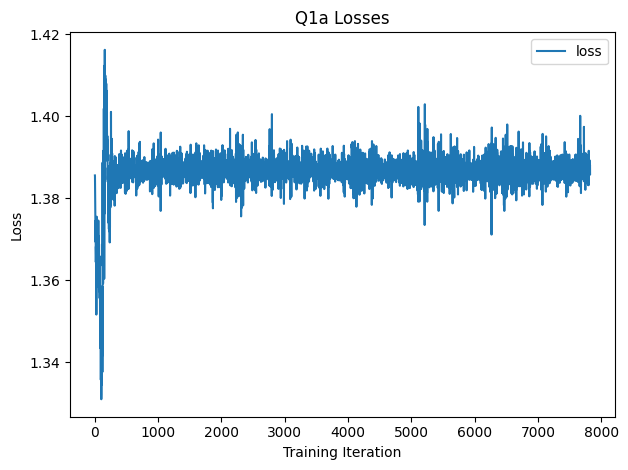

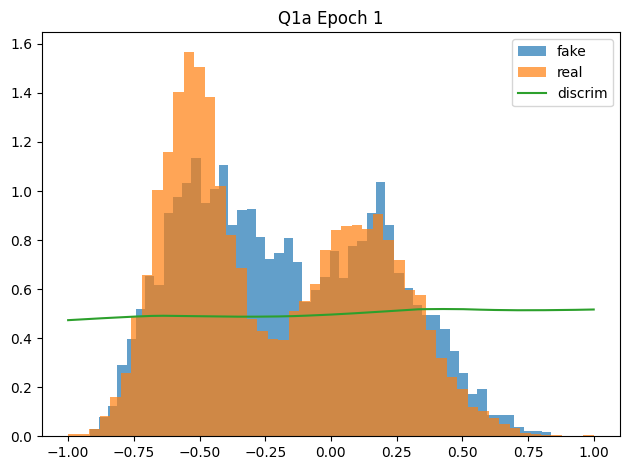

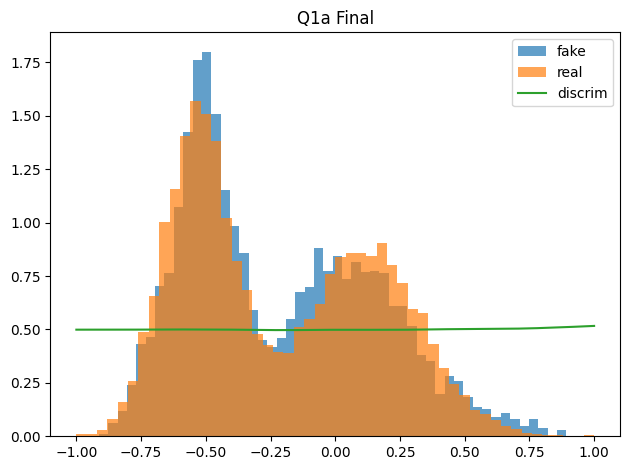

In [15]:
q1_save_results("a", q1_a)

## Part 1(b)
Here, we'll use the non-saturating formulation of the GAN objective. Now, we have two separate losses:
$$L^{(D)} = \mathbb{E}_{x \sim p_{data}} [\log D(x)] + \mathbb{E}_{z \sim p(z)}[\log (1-D(G(z)))]$$
$$L^{(G} = - \mathbb{E}_{z \sim p(z)} \log(D(G(z))$$

 ### Solution

In [18]:
def q1_b(train_data):
    """
    train_data: An (20000, 1) numpy array of floats in [-1, 1]

    Returns
    - a (# of training iterations,) numpy array of discriminator losses evaluated every minibatch
    - a numpy array of size (5000,) of samples drawn from your model at epoch #1
    - a numpy array of size (100,) linearly spaced from [-1, 1]; hint: np.linspace
    - a numpy array of size (100,), corresponding to the discriminator output (after sigmoid)
        at each location in the previous array at epoch #1

    - a numpy array of size (5000,) of samples drawn from your model at the end of training
    - a numpy array of size (1000,) linearly spaced from [-1, 1]; hint: np.linspace
    - a numpy array of size (1000,), corresponding to the discriminator output (after sigmoid)
        at each location in the previous array at the end of training
    """
    # create data loaders
    loader_args = dict(batch_size=128, shuffle=True)
    train_loader = data.DataLoader(train_data, **loader_args)

    # model
    g = MLPGenerator(1, 3, 128, 1).to(ptu.device)
    c = MLPDiscriminator(1, 3, 128, 1).to(ptu.device)

    # loss functions
    def g_loss(generator, critic, x):
        fake_data = generator.sample(x.shape[0])
        return -critic(fake_data).log().mean()

    def c_loss(generator, critic, x):
        fake_data = generator.sample(x.shape[0])
        return -(1 - critic(fake_data)).log().mean() - critic(x).log().mean()

    # train
    train_losses, samples_1, xs_1, critic_1, samples_final, xs_final, critic_final = (
        train_epochs(
            g,
            c,
            g_loss,
            c_loss,
            train_loader,
            dict(epochs=40, lr=1e-4, n_critic=2, q1=True),
        )
    )

    return (
        train_losses["c_losses"],
        samples_1,
        xs_1,
        critic_1,
        samples_final,
        xs_final,
        critic_final,
    )

 ### Results

Epoch:   0%|          | 0/40 [00:00<?, ?it/s]

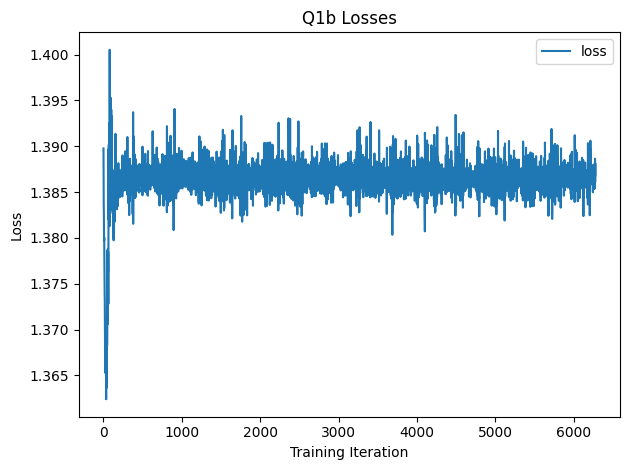

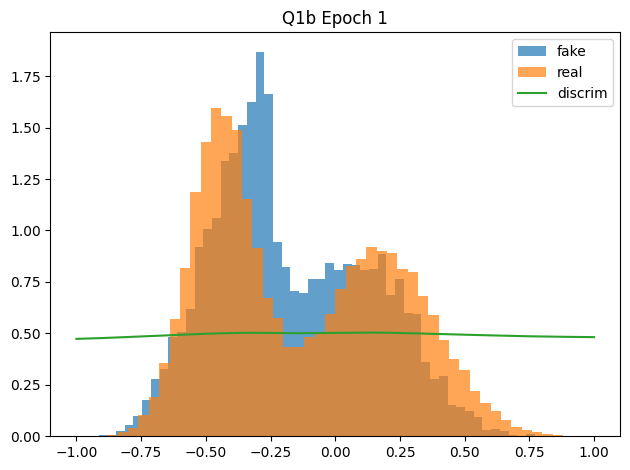

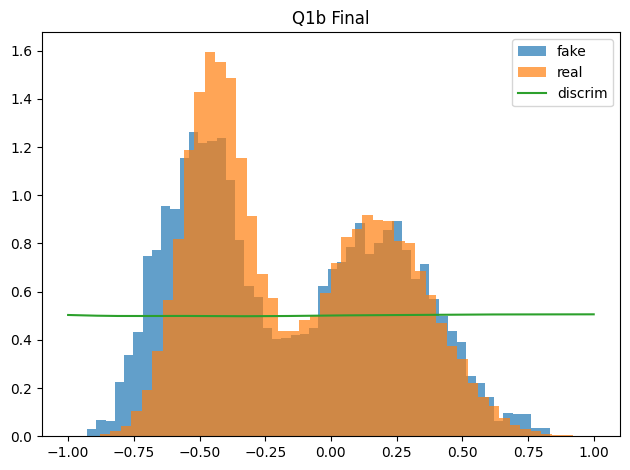

In [19]:
q1_save_results("b", q1_b)

# Question 2: GANs on CIFAR-10 [35pt]

In this exercise, you will train a GAN on CIFAR-10. Execute the cell below to visualize the dataset. 

100%|██████████| 170498071/170498071 [00:04<00:00, 35357359.84it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


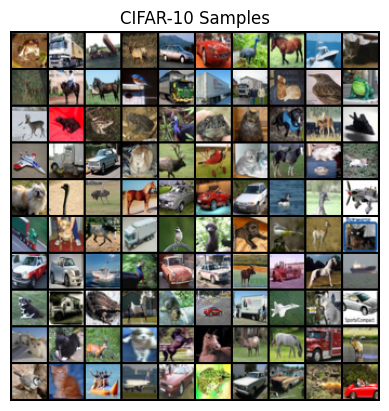

In [20]:
visualize_q2_data()

 We'll use the CIFAR-10 architecture from the [SN-GAN paper](https://arxiv.org/pdf/1802.05957.pdf) (see page 17), with $z \in \mathbb R ^{128}$, with $z \sim \mathcal N (0, I_{128})$. Instead of upsampling via transposed convolutions and downsampling via pooling or striding, we'll use these DepthToSpace and SpaceToDepth methods for changing the spatial configuration of our hidden states. 

```
class DepthToSpace(nn.Module):
    def __init__(self, block_size):
        super().__init__()
        self.block_size = block_size
        self.block_size_sq = block_size * block_size

    def forward(self, input):
        output = input.permute(0, 2, 3, 1)
        (batch_size, d_height, d_width, d_depth) = output.size()
        s_depth = int(d_depth / self.block_size_sq)
        s_width = int(d_width * self.block_size)
        s_height = int(d_height * self.block_size)
        t_1 = output.reshape(batch_size, d_height, d_width, self.block_size_sq, s_depth)
        spl = t_1.split(self.block_size, 3)
        stack = [t_t.reshape(batch_size, d_height, s_width, s_depth) for t_t in spl]
        output = torch.stack(stack, 0).transpose(0, 1).permute(0, 2, 1, 3, 4).reshape(batch_size, s_height, s_width,
                                                                                      s_depth)
        output = output.permute(0, 3, 1, 2)
        return output


class SpaceToDepth(nn.Module):
    def __init__(self, block_size):
        super().__init__()
        self.block_size = block_size
        self.block_size_sq = block_size * block_size

    def forward(self, input):
        output = input.permute(0, 2, 3, 1)
        (batch_size, s_height, s_width, s_depth) = output.size()
        d_depth = s_depth * self.block_size_sq
        d_width = int(s_width / self.block_size)
        d_height = int(s_height / self.block_size)
        t_1 = output.split(self.block_size, 2)
        stack = [t_t.reshape(batch_size, d_height, d_depth) for t_t in t_1]
        output = torch.stack(stack, 1)
        output = output.permute(0, 2, 1, 3)
        output = output.permute(0, 3, 1, 2)
        return output

# Spatial Upsampling with Nearest Neighbors
Upsample_Conv2d(in_dim, out_dim, kernel_size=(3, 3), stride=1, padding=1):
    x = torch.cat([x, x, x, x], dim=1)
    DepthToSpace(block_size=2)
    Conv2d(in_dim, out_dim, kernel_size, stride=stride, padding=padding)


# Spatial Downsampling with Spatial Mean Pooling
Downsample_Conv2d(in_dim, out_dim, kernel_size=(3, 3), stride=1, padding=1):
        SpaceToDepth(2)
        torch.sum(x.chunk(4, dim=1)) / 4.0
        nn.Conv2d(in_dim, out_dim, kernel_size,
                              stride=stride, padding=padding, bias=bias)
```

Here's pseudocode for how we'll implement a ResBlockUp, used in the generator:

```
ResnetBlockUp(x, in_dim, kernel_size=(3, 3), n_filters=256):
    _x = x
    _x = nn.BatchNorm2d(in_dim)(_x)
    _x = nn.ReLU()(_x)
    _x = nn.Conv2d(in_dim, n_filters, kernel_size, padding=1)(_x)
    _x = nn.BatchNorm2d(n_filters)(_x)
    _x = nn.ReLU()(_x)
    residual = Upsample_Conv2d(n_filters, n_filters, kernel_size, padding=1)(_x)
    shortcut = Upsample_Conv2d(in_dim, n_filters, kernel_size=(1, 1), padding=0)(x)
    return residual + shortcut
```
The ResBlockDown module is similar, except it uses Downsample_Conv2d and omits the BatchNorm.

Finally, here's the architecture for the generator:
```
def Generator(*, n_samples=1024, n_filters=128):
    z = Normal(0, 1)([n_samples, 128])
    nn.Linear(128, 4*4*256)
    reshape output of linear layer
    ResnetBlockUp(in_dim=256, n_filters=n_filters),
    ResnetBlockUp(in_dim=n_filters, n_filters=n_filters),
    ResnetBlockUp(in_dim=n_filters, n_filters=n_filters),
    nn.BatchNorm2d(n_filters),
    nn.ReLU(),
    nn.Conv2d(n_filters, 3, kernel_size=(3, 3), padding=1),
    nn.Tanh()
```
The discriminator (no BatchNorm!).
```
def Discriminator(*):
    def __init__(self, n_filters=128):
        ResnetBlockDown(3, n_filters=n_filters),
        ResnetBlockDown(128, n_filters=n_filters),
        ResBlock(n_filters, n_filters=n_filters),
        ResBlock(n_filters, n_filters=n_filters),
        nn.ReLU()
        global sum pooling
        nn.Linear(128, 1)
```


**Hyperparameters**

We'll implement [WGAN-GP](https://arxiv.org/abs/1704.00028), which uses a gradient penalty to regularize the discriminator. Use the Adam optimizer with $\alpha = 2e-4$, $\beta_1 = 0$, $\beta_2 = 0.9$, $\lambda = 10$, $n_{critic} = 5$. Use a batch size of 256 and n_filters=128 within the ResBlocks. Train for at least 25000 gradient steps, with the learning rate linearly annealed to 0 over training. 

**You will provide the following deliverables**
1. Inception score (CIFAR-10 version) of the final model. We provide a utility that will automatically do this for you.
2. Fréchet inception distance (bonus, 5pts)
3. Discriminator loss across training
4. 100 samples. 

## Solution

 ### Models

In [3]:
import torch.nn.utils.spectral_norm as spectral_norm


class DepthToSpace(nn.Module):
    def __init__(self, block_size):
        super(DepthToSpace, self).__init__()
        self.block_size = block_size
        self.block_size_sq = block_size * block_size

    def forward(self, input):
        output = input.permute(0, 2, 3, 1)
        (batch_size, d_height, d_width, d_depth) = output.size()
        s_depth = int(d_depth / self.block_size_sq)
        s_width = int(d_width * self.block_size)
        s_height = int(d_height * self.block_size)
        t_1 = output.reshape(batch_size, d_height, d_width, self.block_size_sq, s_depth)
        spl = t_1.split(self.block_size, 3)
        stack = [t_t.reshape(batch_size, d_height, s_width, s_depth) for t_t in spl]
        output = (
            torch.stack(stack, 0)
            .transpose(0, 1)
            .permute(0, 2, 1, 3, 4)
            .reshape(batch_size, s_height, s_width, s_depth)
        )
        output = output.permute(0, 3, 1, 2)
        return output.contiguous()


class SpaceToDepth(nn.Module):
    def __init__(self, block_size):
        super(SpaceToDepth, self).__init__()
        self.block_size = block_size
        self.block_size_sq = block_size * block_size

    def forward(self, input):
        output = input.permute(0, 2, 3, 1)
        (batch_size, s_height, s_width, s_depth) = output.size()
        d_depth = s_depth * self.block_size_sq
        d_width = int(s_width / self.block_size)
        d_height = int(s_height / self.block_size)
        t_1 = output.split(self.block_size, 2)
        stack = [t_t.reshape(batch_size, d_height, d_depth) for t_t in t_1]
        output = torch.stack(stack, 1)
        output = output.permute(0, 2, 1, 3)
        output = output.permute(0, 3, 1, 2)
        return output.contiguous()


class Upsample_Conv2d(nn.Module):
    def __init__(
        self, in_dim, out_dim, kernel_size=(3, 3), stride=1, padding=1, bias=True
    ):
        super(Upsample_Conv2d, self).__init__()
        self.conv = nn.Conv2d(
            in_dim, out_dim, kernel_size, stride=stride, padding=padding, bias=bias
        )
        self.depth_to_space = DepthToSpace(2)

    def forward(self, x):
        _x = torch.cat([x, x, x, x], dim=1)
        _x = self.depth_to_space(_x)
        _x = self.conv(_x)
        return _x


def maybe_add_spectral_norm(module, add_spectral_norm=False):
    return spectral_norm(module) if add_spectral_norm else module


class Downsample_Conv2d(nn.Module):
    def __init__(
        self,
        in_dim,
        out_dim,
        kernel_size=(3, 3),
        stride=1,
        padding=1,
        bias=True,
        add_spectral_norm=False,
    ):
        super(Downsample_Conv2d, self).__init__()
        self.conv = nn.Conv2d(
            in_dim, out_dim, kernel_size, stride=stride, padding=padding, bias=bias
        )
        self.conv = maybe_add_spectral_norm(
            self.conv, add_spectral_norm=add_spectral_norm
        )
        self.space_to_depth = SpaceToDepth(2)

    def forward(self, x):
        _x = self.space_to_depth(x)
        _x = sum(_x.chunk(4, dim=1)) / 4.0
        _x = self.conv(_x)
        return _x


class ResnetBlockUp(nn.Module):
    def __init__(self, in_dim, kernel_size=(3, 3), n_filters=256):
        super(ResnetBlockUp, self).__init__()
        self.layers = nn.ModuleList(
            [
                nn.BatchNorm2d(in_dim),
                nn.ReLU(),
                nn.Conv2d(in_dim, n_filters, kernel_size, padding=1),
                nn.BatchNorm2d(n_filters),
                nn.ReLU(),
                Upsample_Conv2d(n_filters, n_filters, kernel_size, padding=1),
                Upsample_Conv2d(in_dim, n_filters, kernel_size=(1, 1), padding=0),
            ]
        )

    def forward(self, x):
        _x = x
        for i in range(len(self.layers) - 1):
            _x = self.layers[i](_x)
        return self.layers[-1](x) + _x


class ResnetBlockDown(nn.Module):
    def __init__(
        self,
        in_dim,
        kernel_size=(3, 3),
        stride=1,
        n_filters=256,
        add_spectral_norm=False,
        leaky_relu=False,
    ):
        super(ResnetBlockDown, self).__init__()
        relu_cls = nn.LeakyReLU if leaky_relu else nn.ReLU
        self.layers = nn.ModuleList(
            [
                relu_cls(),
                maybe_add_spectral_norm(
                    nn.Conv2d(in_dim, n_filters, kernel_size, stride=stride, padding=1),
                    add_spectral_norm=add_spectral_norm,
                ),
                relu_cls(),
                Downsample_Conv2d(
                    n_filters,
                    n_filters,
                    kernel_size,
                    add_spectral_norm=add_spectral_norm,
                ),
                Downsample_Conv2d(
                    in_dim,
                    n_filters,
                    kernel_size=(1, 1),
                    padding=0,
                    add_spectral_norm=add_spectral_norm,
                ),
            ]
        )

    def forward(self, x):
        _x = x
        for i in range(len(self.layers) - 1):
            _x = self.layers[i](_x)
        return self.layers[-1](x) + _x


class ResBlock(nn.Module):
    def __init__(
        self,
        in_dim,
        kernel_size=(3, 3),
        n_filters=256,
        add_spectral_norm=False,
        leaky_relu=False,
    ):
        super(ResBlock, self).__init__()
        relu_cls = nn.LeakyReLU if leaky_relu else nn.ReLU
        self.layers = nn.ModuleList(
            [
                relu_cls(),
                maybe_add_spectral_norm(
                    nn.Conv2d(in_dim, n_filters, kernel_size, padding=1),
                    add_spectral_norm=add_spectral_norm,
                ),
                relu_cls(),
                maybe_add_spectral_norm(
                    nn.Conv2d(n_filters, n_filters, kernel_size, padding=1),
                    add_spectral_norm=add_spectral_norm,
                ),
            ]
        )

    def forward(self, x):
        _x = x
        for op in self.layers:
            _x = op(_x)
        return x + _x


class Generator(nn.Module):
    def __init__(self, n_filters=256):
        super(Generator, self).__init__()
        self.fc = nn.Linear(128, 4 * 4 * 256)
        network = [
            ResnetBlockUp(in_dim=256, n_filters=n_filters),
            ResnetBlockUp(in_dim=n_filters, n_filters=n_filters),
            ResnetBlockUp(in_dim=n_filters, n_filters=n_filters),
            nn.BatchNorm2d(n_filters),
            nn.ReLU(),
            nn.Conv2d(n_filters, 3, kernel_size=(3, 3), padding=1),
            nn.Tanh(),
        ]
        self.net = nn.Sequential(*network)
        self.noise = torch.distributions.Normal(torch.tensor(0.0), torch.tensor(1.0))

    def forward(self, z):
        z = self.fc(z).reshape(-1, 256, 4, 4)
        return self.net(z)

    def sample(self, n_samples):
        z = self.noise.sample([n_samples, 128]).to(ptu.device)
        return self.forward(z)


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        network = [
            ResnetBlockDown(3, n_filters=128),
            ResnetBlockDown(128, n_filters=128),
            ResBlock(128, n_filters=128),
            ResBlock(128, n_filters=128),
            nn.ReLU(),
        ]
        self.net = nn.Sequential(*network)
        self.fc = nn.Linear(128, 1)

    def forward(self, z):
        z = self.net(z)
        z = torch.sum(z, dim=(2, 3))
        return self.fc(z)

In [4]:
class Solver(object):
    def __init__(self, train_data, n_iterations=50000, batch_size=256, n_filters=128):
        self.n_critic = 5
        self.log_interval = 100
        self.batch_size = batch_size
        self.n_filters = n_filters
        self.train_loader = self.create_loaders(train_data)
        self.n_batches_in_epoch = len(self.train_loader)
        # Number of epochs to train in order to have n_iterations of the
        # generator, meaning that do a gradient update for the generator
        # n_iterations times.
        self.n_epochs = self.n_critic * n_iterations // self.n_batches_in_epoch
        self.n_iterations = n_iterations
        self.curr_itr = 0

    def build(self, part_name):
        self.g = Generator(n_filters=self.n_filters).to(ptu.device)
        self.d = Discriminator().to(ptu.device)
        self.g_optimizer = torch.optim.Adam(
            self.g.parameters(), lr=2e-4, betas=(0, 0.9)
        )
        self.g_scheduler = torch.optim.lr_scheduler.LambdaLR(
            self.g_optimizer,
            lambda iter: (self.n_iterations - iter) / self.n_iterations,
            last_epoch=-1,
        )
        self.d_optimizer = torch.optim.Adam(
            self.d.parameters(), lr=2e-4, betas=(0, 0.9)
        )
        self.d_scheduler = torch.optim.lr_scheduler.LambdaLR(
            self.d_optimizer,
            lambda iter: (self.n_iterations - iter) / self.n_iterations,
            last_epoch=-1,
        )
        self.part_name = part_name

    def create_loaders(self, train_data):
        train_loader = data.DataLoader(
            train_data, batch_size=self.batch_size, shuffle=True
        )
        return train_loader

    def gradient_penalty(self, real_data, fake_data):
        batch_size = real_data.shape[0]

        # Calculate interpolation
        eps = torch.rand(batch_size, 1, 1, 1).to(ptu.device)
        eps = eps.expand_as(real_data)
        interpolated = eps * real_data.data + (1 - eps) * fake_data.data
        interpolated.requires_grad = True

        d_output = self.d(interpolated)
        gradients = torch.autograd.grad(
            outputs=d_output,
            inputs=interpolated,
            grad_outputs=torch.ones(d_output.size()).to(ptu.device),
            create_graph=True,
            retain_graph=True,
        )[0]

        gradients = gradients.reshape(batch_size, -1)
        gradients_norm = torch.sqrt(torch.sum(gradients**2, dim=1) + 1e-12)
        return ((gradients_norm - 1) ** 2).mean()

    def train(self, verbose=False, checkpoint_freq=100):
        train_g_losses = []
        train_d_losses = []
        for epoch_i in tqdm_notebook(range(self.n_epochs), desc="Epoch", leave=False):
            # epoch_i += 1

            self.d.train()
            self.g.train()
            g_batch_loss_history = []
            d_batch_loss_history = []

            for batch_i, x in enumerate(
                tqdm_notebook(self.train_loader, desc="Batch", leave=False)
            ):
                self.curr_itr += 1
                x = ptu.tensor(x).float()
                # Normalize x to [-1, 1].
                x = 2 * (x - 0.5)

                # do a critic update
                self.d_optimizer.zero_grad()
                fake_data = self.g.sample(x.shape[0])
                gp = self.gradient_penalty(x, fake_data)
                d_fake_loss = self.d(fake_data).mean()
                d_real_loss = self.d(x).mean()
                d_loss = d_fake_loss - d_real_loss + 10 * gp
                d_loss.backward()
                self.d_optimizer.step()
                d_batch_loss_history.append(d_loss.data.cpu().numpy())

                # generator update
                if self.curr_itr % self.n_critic == 0:
                    self.g_optimizer.zero_grad()
                    fake_data = self.g.sample(self.batch_size)
                    g_loss = -self.d(fake_data).mean()
                    g_loss.backward()
                    self.g_optimizer.step()

                    # step the learning rate
                    self.g_scheduler.step()
                    self.d_scheduler.step()

                    g_batch_loss_history.append(g_loss.data.cpu().numpy())

                    if verbose:
                        print(
                            f"Epoch {epoch_i}, Batch {batch_i}: D loss: {d_loss.data.cpu().numpy()}, D fake loss: {d_fake_loss.data.cpu().numpy()}, D real loss: {d_real_loss.data.cpu().numpy()}, GP: {gp.data.cpu().numpy()} G loss: {g_loss.data.cpu().numpy()}, G LR: {self.g_scheduler.get_last_lr()}, D LR: {self.d_scheduler.get_last_lr()}"
                        )

            g_epoch_loss = np.mean(g_batch_loss_history)
            train_g_losses.append(g_epoch_loss)
            d_epoch_loss = np.mean(d_batch_loss_history)
            train_d_losses.append(d_epoch_loss)
            np.save("q2_train_g_losses.npy", np.array(train_g_losses))
            np.save("q2_train_d_losses.npy", np.array(train_d_losses))

            # Save a checkpoint.
            if epoch_i % checkpoint_freq == 0:
                self.save_model(f"{self.part_name}_epoch_{epoch_i}.pt")

        train_g_losses = np.array(train_g_losses)
        self.save_model(f"{self.part_name}.pt")
        return train_g_losses

    def save_model(self, filename):
        torch.save(self.g.state_dict(), "g_" + filename)
        torch.save(self.d.state_dict(), "d_" + filename)

    def load_model(self, filename):
        d_path = "d_" + filename
        g_path = "g_" + filename
        self.d.load_state_dict(torch.load(d_path))
        self.g.load_state_dict(torch.load(g_path))

In [5]:
def q2(train_data, load=True, load_epoch="final"):
    """
    train_data: An (n_train, 3, 32, 32) numpy array of CIFAR-10 images with values in [0, 1]

    Returns
    - a (# of training iterations,) numpy array of WGAN critic train losses evaluated every minibatch
    - a (1000, 32, 32, 3) numpy array of samples from your model in [0, 1].
        The first 100 will be displayed, and the rest will be used to calculate the Inception score.
    """
    solver = Solver(train_data, n_iterations=50000)
    solver.build("q2")
    if load:
        solver.load_model(f"q2_{load_epoch}.pt")
        train_d_losses = np.load("q2_train_d_losses.npy")
    else:
        train_g_losses, train_d_losses = solver.train(verbose=True)

    solver.g.eval()
    solver.d.eval()
    with torch.no_grad():
        samples = solver.g.sample(1000)
        samples = ptu.get_numpy(samples.permute(0, 2, 3, 1)) * 0.5 + 0.5

    return train_d_losses, samples

## Results

Files already downloaded and verified
..........Inception score: 7.933057


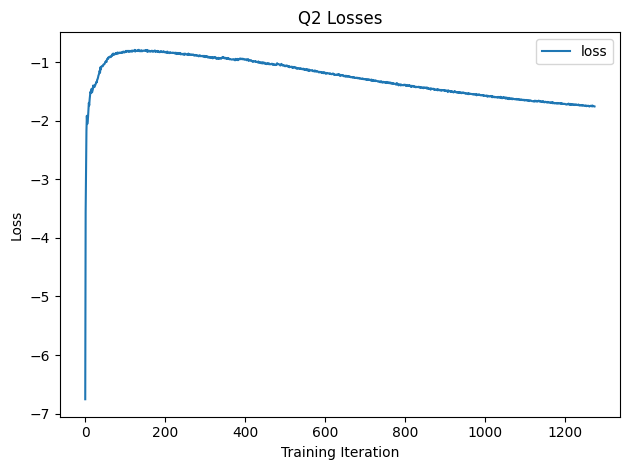

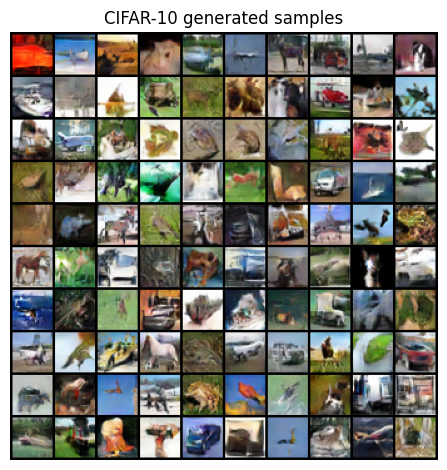

In [31]:
q2_save_results(q2)

# Question 3 : Quantization with GANS [40pt]
In this question, you'll train a variants of the VQGAN model to learn a mapping between image and a discrete codebook. We will do this on the CIFAR10 dataset.

## Part a: Vanilla VQGAN [25]
[VQGAN](https://github.com/CompVis/taming-transformers) extends the ideas from VQVAE by adding an additional GAN loss. Review HW 2 for more details on VQVAE, and may use your code from HW 2 (or HW2 solutions) to help with this question. Conceptually, the training procedure is the same as VQVAE, but with the addition of a discriminator network and its training.

Following the original VQGAN paper, we will use a patch-based discriminator. Split the image into 8x8 patches, which will be then fed into the discriminator. For the discrimiator you can use an architecture similar to the one used in the previous questions.
```
def Discriminator(*, n_filters=128):
    split to 8x8 patches
    ResnetBlockDown(3, n_filters=n_filters),
    ResnetBlockDown(128, n_filters=n_filters),
    ResBlock(n_filters, n_filters=n_filters),
    ResBlock(n_filters, n_filters=n_filters),
    nn.ReLU()
    global sum pooling
    nn.Linear(128, 1)
```

**Loss function**
We will use the loss function of

$L = L_{VQ} + 0.1 L_{GAN} + 0.5 L_{perceptual} + L_2$

Where $L_{VQ}$ is the VQ objective, $L_{GAN}$ is the GAN loss, $L_{perceptual}$ is the perceptual loss. 

For pytorch users, we provide the LPIPS loss from the original taming transformers paper ([found here](https://github.com/CompVis/taming-transformers/blob/master/taming/modules/losses/lpips.py)). An example of using the LPIPS loss is found below. If you are using a different framework, feel free to use any off the shelf code, just make sure to cite where you take it from.

Instead of using the adaptive weight on the GAN loss, we will use a fixed weight of 0.1.
* train for at least 15 epochs
* use a codebook size of 1024
* use Adam with betas=(0.5, 0.9) and 0 weight decay for both optimizers
* use the non-saturating formulation of the GAN objective.

**You will provide the following deliverables**
1. Final L2 reconstruction loss
2. Discriminator loss across training
3. $L_{perceptual}$ loss across training
4. Training l2 loss across training
5. Validation l2 reconstruction loss across training, evaluated at the end of every epoch
6. 100 reconstructions of the validation set.

In [5]:
# example usage of the LPIPS loss
# from deepul.hw3_utils.lpips import LPIPS

# loss = LPIPS()
# x = torch.zeros(4, 3, 32, 32)
# print(loss(x, x).mean())

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

from einops import repeat
from vit_pytorch import ViT

import vit
from deepul.hw3_utils.lpips import LPIPS


class VQDiscriminator(nn.Module):
    def __init__(
        self, n_filters=128, leaky_relu=False, patchify=True, add_spectral_norm=False
    ):
        super(VQDiscriminator, self).__init__()
        network = [
            ResnetBlockDown(
                3,
                n_filters=n_filters,
                add_spectral_norm=add_spectral_norm,
                leaky_relu=leaky_relu,
            ),
            ResnetBlockDown(
                n_filters,
                n_filters=n_filters,
                add_spectral_norm=add_spectral_norm,
                leaky_relu=leaky_relu,
            ),
            ResBlock(
                n_filters,
                n_filters=n_filters,
                add_spectral_norm=add_spectral_norm,
                leaky_relu=leaky_relu,
            ),
            ResBlock(
                n_filters,
                n_filters=n_filters,
                add_spectral_norm=add_spectral_norm,
                leaky_relu=leaky_relu,
            ),
        ]
        if leaky_relu:
            network.append(nn.LeakyReLU())
        else:
            network.append(nn.ReLU())
        self.net = nn.Sequential(*network)
        self.fc = maybe_add_spectral_norm(
            nn.Linear(n_filters, 1), add_spectral_norm=add_spectral_norm
        )

        # self.process_z = self.patchify if patchify else nn.Identity()

    def patchify(self, z):
        bs, nc, h, w = z.shape
        # Split z into 8x8 patches
        z = z.unfold(2, 8, 8).unfold(3, 8, 8)
        z = (
            z.contiguous()
            .view(bs, nc, -1, 8, 8)
            .permute(0, 2, 1, 3, 4)
            .contiguous()
            .view(-1, nc, 8, 8)
        )
        return z

    def forward(self, z):
        if self.patchify:
            z = self.patchify(z)

        z = self.net(z)
        z = torch.sum(z, dim=(2, 3))
        return torch.sigmoid(self.fc(z))


class VQGAN(object):
    def __init__(
        self,
        train_data,
        val_data,
        reconstruct_data,
        batch_size=256,
        n_filters=128,
        code_dim=256,
        code_size=1024,
        num_epochs=15,
        vit_vqgan: bool = False,
        use_scheduler: bool = True,
        retain_graph: bool = False,
    ):
        self.train_loader = self.create_loaders(train_data, batch_size, shuffle=True)
        self.val_loader = self.create_loaders(val_data, batch_size, shuffle=False)
        self.reconstruct_loader = self.create_loaders(
            reconstruct_data, batch_size, shuffle=False
        )

        # Initialize models, optimizers, and loss functions
        self.vit_vqgan = vit_vqgan
        if vit_vqgan:
            quantizer_kwargs = {"beta": 1, "use_norm": True, "embed_init": "uniform"}
            self.generator = vit.ViTVQ(
                image_size=32, patch_size=4, quantizer_kwargs=quantizer_kwargs
            ).to(ptu.device)
            self.discriminator = VQDiscriminator(
                n_filters=n_filters,
                leaky_relu=False,  # NOTE: True is suggested.
                patchify=False,
                add_spectral_norm=True,
            ).to(ptu.device)
            g_lr = 2e-4
            betas = (0.5, 0.9)
        else:
            self.generator = vqvae.VQVAE(
                code_dim=code_dim, code_size=code_size, decoder_tanh=True
            ).to(ptu.device)
            self.discriminator = VQDiscriminator(
                n_filters=n_filters,
                leaky_relu=False,
                patchify=True,
                add_spectral_norm=False,
            ).to(ptu.device)
            g_lr = 2e-4
            betas = (0.5, 0.9)

        self.g_optimizer = optim.Adam(self.generator.parameters(), lr=g_lr, betas=betas)
        self.d_optimizer = optim.Adam(
            self.discriminator.parameters(), lr=2e-4, betas=betas
        )

        num_batches_in_epoch = len(self.train_loader)
        self.n_iterations = num_epochs * num_batches_in_epoch
        self.g_scheduler = torch.optim.lr_scheduler.LambdaLR(
            self.g_optimizer,
            lambda iter: (self.n_iterations - iter) / self.n_iterations,
            last_epoch=-1,
        )
        self.d_scheduler = torch.optim.lr_scheduler.LambdaLR(
            self.d_optimizer,
            lambda iter: (self.n_iterations - iter) / self.n_iterations,
            last_epoch=-1,
        )

        self.lpips_loss_fn = LPIPS().eval().to(ptu.device)

        self.num_epochs = num_epochs
        self.use_scheduler = use_scheduler
        self.retain_graph = retain_graph

    def create_loaders(self, data, batch_size, shuffle=True):
        assert data.min() >= 0 and data.max() <= 1
        data = (data * 2) - 1
        assert data.min() >= -1 and data.max() <= 1
        dataset = TensorDataset(torch.tensor(data).float())
        return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

    def train(self, verbose=False, log_freq=100):
        # Placeholder for losses
        discriminator_losses = []
        l_pips_losses = []
        l2_recon_train = []
        l2_recon_test = []

        iter = 0

        # Training loop
        for epoch in range(self.num_epochs):
            self.generator.train()
            self.discriminator.train()

            for i, (real_data,) in enumerate(
                tqdm_notebook(self.train_loader, desc="Batch", leave=False)
            ):
                self.d_optimizer.zero_grad()
                self.g_optimizer.zero_grad()

                # Training discriminator
                real_data = ptu.tensor(real_data)
                # if self.vit_vqgan:
                #     fake_data, _ = self.generator(real_data)
                # else:
                #     fake_data = self.generator.reconstruct(real_data)
                # NOTE: g_reg_loss is unused if self.retain_graph = False.
                fake_data, g_reg_loss = self.generator(real_data)
                d_real_loss = -(self.discriminator(real_data) + 1e-8).log().mean()
                d_fake_pred = self.discriminator(fake_data)
                d_fake_loss = -(1 - d_fake_pred + 1e-8).log().mean()
                # d_loss is same as loss_d (ignoring weighting factor)
                d_loss = 0.1 * (d_fake_loss + d_real_loss)
                d_loss.backward(retain_graph=self.retain_graph)
                d_loss_val = d_loss.item()
                discriminator_losses.append(d_loss_val)

                # Training generator
                if not self.retain_graph:
                    fake_data, g_reg_loss = self.generator(real_data)
                    d_fake_pred = self.discriminator(fake_data)
                # g_gan_loss is same as loss_g
                g_gan_loss = -(d_fake_pred + 1e-8).log().mean()
                l2_loss = nn.MSELoss()(real_data, fake_data)
                lpips_loss = self.lpips_loss_fn(real_data, fake_data).mean()
                g_loss = 0.1 * g_gan_loss + g_reg_loss + 0.5 * lpips_loss + l2_loss
                if self.vit_vqgan:
                    l1_loss = nn.L1Loss()(real_data, fake_data).mean()
                    g_loss += 0.1 * l1_loss
                g_loss.backward()
                l_pips_losses.append(lpips_loss.item())
                l2_recon_train.append(l2_loss.item())

                # Step the optimizers
                self.d_optimizer.step()
                self.g_optimizer.step()

                # Step the learning rate
                if self.use_scheduler:
                    self.g_scheduler.step()
                    self.d_scheduler.step()

                if verbose and iter % log_freq == 0:
                    print(f"Epoch {epoch}, Batch {i}:")
                    print(
                        f"G loss: {g_loss.item()}, "
                        f"G GAN loss: {g_gan_loss.item()},"
                        f"G reg loss: {g_reg_loss.item()}, "
                        f"LPIPS loss: {lpips_loss.item()}, "
                        f"L2 loss: {l2_loss.item()}, "
                        f"L1 loss: {l1_loss.item() if self.vit_vqgan else 'None'}, "
                        f"G LR: {self.g_scheduler.get_last_lr()}"
                    )
                    print(
                        f"D loss: {d_loss_val}, "
                        f"D real loss: {d_real_loss.item()}, "
                        f"D fake loss: {d_fake_loss.item()}, "
                        f"D LR: {self.d_scheduler.get_last_lr()}"
                    )

                iter += 1

            # Evaluate on validation set
            self.generator.eval()
            l2_losses_val = []
            with torch.no_grad():
                for i, (val_data,) in enumerate(self.val_loader):
                    # [batch_size, channels, height, width]
                    val_data = ptu.tensor(val_data)
                    if self.vit_vqgan:
                        # [batch_size, channels, height, width]
                        recon_val_data, _ = self.generator(val_data)
                    else:
                        # [batch_size, height, width, channels]
                        recon_val_data = self.generator.decode(
                            self.generator.encode(val_data)
                        )
                        recon_val_data = ptu.tensor(recon_val_data).permute(0, 3, 1, 2)
                    l2_loss_val = nn.MSELoss()(val_data, recon_val_data)
                    l2_losses_val.append(l2_loss_val.item())
            l2_recon_test.append(np.mean(l2_losses_val))

        return discriminator_losses, l_pips_losses, l2_recon_train, l2_recon_test

    def reconstruct(self):
        reconstructions = []
        self.generator.eval()
        for i, (data,) in enumerate(self.reconstruct_loader):
            data = ptu.tensor(data)
            if self.vit_vqgan:
                with torch.no_grad():
                    # [batch_size, channels, height, width]
                    recon_data, _ = self.generator(data)
                    # [batch_size, height, width, channels]
                    recon_data = recon_data.permute(0, 2, 3, 1).cpu().numpy()
            else:
                # [batch_size, height, width, channels]
                recon_data = self.generator.decode(self.generator.encode(data))
            reconstructions.append(recon_data)

        reconstructions = np.concatenate(reconstructions, axis=0)
        assert reconstructions.min() >= -1 and reconstructions.max() <= 1
        reconstructions = np.clip(reconstructions, -1, 1)
        # Normalize to [0, 1].
        reconstructions = (reconstructions + 1) / 2
        return reconstructions

In [7]:
def q3a(train_data, val_data, reconstruct_data):
    """
    train_data: An (n_train, 3, 32, 32) numpy array of CIFAR-10 images with values in [0, 1]
    val_data: An (n_train, 3, 32, 32) numpy array of CIFAR-10 images with values in [0, 1]
    reconstruct_data: An (100, 3, 32, 32) numpy array of CIFAR-10 images with values in [0, 1]. To be used for reconstruction

    Returns
    - a (# of training iterations,) numpy array of the discriminator train losses evaluated every minibatch
    - None or a (# of training iterations,) numpy array of the perceptual train losses evaluated every minibatch
    - a (# of training iterations,) numpy array of the l2 reconstruction evaluated every minibatch
    - a (# of epochs + 1,) numpy array of l2 reconstruction loss evaluated once at initialization and after each epoch on the val_data
    - a (100, 32, 32, 3) numpy array of reconstructions from your model in [0, 1] on the reconstruct_data.
    """
    vqgan = VQGAN(
        train_data,
        val_data,
        reconstruct_data,
        num_epochs=15,
        vit_vqgan=False,
        use_scheduler=True,
    )
    discriminator_losses, l_pips_losses, l2_recon_train, l2_recon_test = vqgan.train(
        verbose=True, log_freq=10
    )
    reconstructions = vqgan.reconstruct()

    return (
        discriminator_losses,
        l_pips_losses,
        l2_recon_train,
        l2_recon_test,
        reconstructions,
    )

Files already downloaded and verified
Files already downloaded and verified
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth


Batch:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 0, Batch 0:
G loss: 2.6645119190216064, G GAN loss: 0.7253297567367554,G reg loss: 1.2527142763137817, LPIPS loss: 0.7471027374267578, L2 loss: 0.9657132029533386, L1 loss: None, G LR: [0.00019993197278911565]
D loss: 0.13567370176315308, D real loss: 0.6940617561340332, D fake loss: 0.6626752614974976, D LR: [0.00019993197278911565]
Epoch 0, Batch 10:
G loss: 6.091389179229736, G GAN loss: 0.4942752718925476,G reg loss: 5.387577056884766, LPIPS loss: 0.6008440852165222, L2 loss: 0.35396242141723633, L1 loss: None, G LR: [0.0001992517006802721]
D loss: 0.12694627046585083, D real loss: 0.29060477018356323, D fake loss: 0.9788579344749451, D LR: [0.0001992517006802721]
Epoch 0, Batch 20:
G loss: 8.386778831481934, G GAN loss: 0.4303569495677948,G reg loss: 7.873442649841309, LPIPS loss: 0.5725040435791016, L2 loss: 0.1840488612651825, L1 loss: None, G LR: [0.0001985714285714286]
D loss: 0.1437731236219406, D real loss: 0.3187427222728729, D fake loss: 1.1189885139465332, D LR: [0.

Batch:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1, Batch 4:
G loss: 7.89480447769165, G GAN loss: 0.43722283840179443,G reg loss: 7.633050918579102, LPIPS loss: 0.33721616864204407, L2 loss: 0.04942312091588974, L1 loss: None, G LR: [0.0001863265306122449]
D loss: 0.1275690495967865, D real loss: 0.189274400472641, D fake loss: 1.0864160060882568, D LR: [0.0001863265306122449]
Epoch 1, Batch 14:
G loss: 7.680960655212402, G GAN loss: 0.555569589138031,G reg loss: 7.400839805603027, LPIPS loss: 0.34154826402664185, L2 loss: 0.05379033088684082, L1 loss: None, G LR: [0.00018564625850340136]
D loss: 0.11134622246026993, D real loss: 0.2436150312423706, D fake loss: 0.8698472380638123, D LR: [0.00018564625850340136]
Epoch 1, Batch 24:
G loss: 7.323329925537109, G GAN loss: 0.6223136782646179,G reg loss: 7.045096397399902, LPIPS loss: 0.33079302310943604, L2 loss: 0.05060550197958946, L1 loss: None, G LR: [0.00018496598639455782]
D loss: 0.10328894108533859, D real loss: 0.25186845660209656, D fake loss: 0.7810209393501282, D LR: [

Batch:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 2, Batch 8:
G loss: 3.9038500785827637, G GAN loss: 0.6340457201004028,G reg loss: 3.607738494873047, LPIPS loss: 0.3248528242111206, L2 loss: 0.07028055936098099, L1 loss: None, G LR: [0.00017272108843537415]
D loss: 0.11407258361577988, D real loss: 0.3609362244606018, D fake loss: 0.7797895669937134, D LR: [0.00017272108843537415]
Epoch 2, Batch 18:
G loss: 3.783961772918701, G GAN loss: 0.5497559309005737,G reg loss: 3.5236523151397705, LPIPS loss: 0.31536245346069336, L2 loss: 0.04765283688902855, L1 loss: None, G LR: [0.0001720408163265306]
D loss: 0.1043664738535881, D real loss: 0.1657141149044037, D fake loss: 0.8779506087303162, D LR: [0.0001720408163265306]
Epoch 2, Batch 28:
G loss: 3.630585193634033, G GAN loss: 0.5607351660728455,G reg loss: 3.3770642280578613, LPIPS loss: 0.2982169985771179, L2 loss: 0.048339080065488815, L1 loss: None, G LR: [0.00017136054421768707]
D loss: 0.10741402953863144, D real loss: 0.22130876779556274, D fake loss: 0.8528314828872681, D L

Batch:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 3, Batch 2:
G loss: 2.2930562496185303, G GAN loss: 0.6338388919830322,G reg loss: 2.03248929977417, LPIPS loss: 0.29839450120925903, L2 loss: 0.047985829412937164, L1 loss: None, G LR: [0.00015979591836734694]
D loss: 0.08631200343370438, D real loss: 0.1016329899430275, D fake loss: 0.7614870071411133, D LR: [0.00015979591836734694]
Epoch 3, Batch 12:
G loss: 2.2413649559020996, G GAN loss: 0.5207882523536682,G reg loss: 1.9958977699279785, LPIPS loss: 0.29203611612319946, L2 loss: 0.04737044498324394, L1 loss: None, G LR: [0.00015911564625850343]
D loss: 0.10540229082107544, D real loss: 0.09463531523942947, D fake loss: 0.9593875408172607, D LR: [0.00015911564625850343]
Epoch 3, Batch 22:
G loss: 2.1748623847961426, G GAN loss: 0.626460075378418,G reg loss: 1.9140301942825317, LPIPS loss: 0.3012639582157135, L2 loss: 0.04755420610308647, L1 loss: None, G LR: [0.00015843537414965989]
D loss: 0.09066267311573029, D real loss: 0.1319025158882141, D fake loss: 0.7747241854667664,

Batch:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 4, Batch 6:
G loss: 1.5844532251358032, G GAN loss: 0.792526364326477,G reg loss: 1.3119394779205322, LPIPS loss: 0.2944088578224182, L2 loss: 0.04605674743652344, L1 loss: None, G LR: [0.0001461904761904762]
D loss: 0.08652760833501816, D real loss: 0.26077258586883545, D fake loss: 0.6045035123825073, D LR: [0.0001461904761904762]
Epoch 4, Batch 16:
G loss: 1.6161319017410278, G GAN loss: 0.6563478708267212,G reg loss: 1.3689842224121094, LPIPS loss: 0.27620673179626465, L2 loss: 0.04340963065624237, L1 loss: None, G LR: [0.00014551020408163265]
D loss: 0.07470507174730301, D real loss: 0.012283317744731903, D fake loss: 0.7347673773765564, D LR: [0.00014551020408163265]
Epoch 4, Batch 26:
G loss: 1.5465444326400757, G GAN loss: 0.7268003821372986,G reg loss: 1.2912160158157349, LPIPS loss: 0.2768843173980713, L2 loss: 0.04420621320605278, L1 loss: None, G LR: [0.0001448299319727891]
D loss: 0.06969307363033295, D real loss: 0.03260378912091255, D fake loss: 0.6643269062042236,

Batch:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 5, Batch 0:
G loss: 1.4005546569824219, G GAN loss: 0.6755959987640381,G reg loss: 1.1447422504425049, LPIPS loss: 0.2823795676231384, L2 loss: 0.047062959522008896, L1 loss: None, G LR: [0.00013326530612244898]
D loss: 0.07937312126159668, D real loss: 0.07944021373987198, D fake loss: 0.714290976524353, D LR: [0.00013326530612244898]
Epoch 5, Batch 10:
G loss: 1.3527483940124512, G GAN loss: 0.6765130162239075,G reg loss: 1.109819769859314, LPIPS loss: 0.26396095752716064, L2 loss: 0.04329676181077957, L1 loss: None, G LR: [0.00013258503401360544]
D loss: 0.07175284624099731, D real loss: 0.005902741104364395, D fake loss: 0.7116256952285767, D LR: [0.00013258503401360544]
Epoch 5, Batch 20:
G loss: 1.3316563367843628, G GAN loss: 0.6915057301521301,G reg loss: 1.0846481323242188, LPIPS loss: 0.2694334089756012, L2 loss: 0.04314091056585312, L1 loss: None, G LR: [0.0001319047619047619]
D loss: 0.0702405571937561, D real loss: 0.005147665739059448, D fake loss: 0.697257876396179

Batch:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 6, Batch 4:
G loss: 1.1735016107559204, G GAN loss: 0.6874045729637146,G reg loss: 0.9336144924163818, LPIPS loss: 0.2599025368690491, L2 loss: 0.041195448487997055, L1 loss: None, G LR: [0.00011965986394557825]
D loss: 0.07032186537981033, D real loss: 0.0018440282437950373, D fake loss: 0.7013745903968811, D LR: [0.00011965986394557825]
Epoch 6, Batch 14:
G loss: 1.1689523458480835, G GAN loss: 0.686814546585083,G reg loss: 0.9307478666305542, LPIPS loss: 0.2616279125213623, L2 loss: 0.038709044456481934, L1 loss: None, G LR: [0.0001189795918367347]
D loss: 0.07115890085697174, D real loss: 0.01166020892560482, D fake loss: 0.6999287605285645, D LR: [0.0001189795918367347]
Epoch 6, Batch 24:
G loss: 1.1866375207901, G GAN loss: 0.6858508586883545,G reg loss: 0.9458532333374023, LPIPS loss: 0.25801149010658264, L2 loss: 0.043193504214286804, L1 loss: None, G LR: [0.00011829931972789116]
D loss: 0.07144909352064133, D real loss: 0.01210057083517313, D fake loss: 0.702390372753143

Batch:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 7, Batch 8:
G loss: 1.0355702638626099, G GAN loss: 0.6835899949073792,G reg loss: 0.8018483519554138, LPIPS loss: 0.253459095954895, L2 loss: 0.038633376359939575, L1 loss: None, G LR: [0.00010605442176870748]
D loss: 0.07105870544910431, D real loss: 0.0018931489903479815, D fake loss: 0.7086938619613647, D LR: [0.00010605442176870748]
Epoch 7, Batch 18:
G loss: 1.0648030042648315, G GAN loss: 0.6871903538703918,G reg loss: 0.8264201879501343, LPIPS loss: 0.25719767808914185, L2 loss: 0.04106495901942253, L1 loss: None, G LR: [0.00010537414965986394]
D loss: 0.07103662937879562, D real loss: 0.009908216074109077, D fake loss: 0.7004580497741699, D LR: [0.00010537414965986394]
Epoch 7, Batch 28:
G loss: 1.039720058441162, G GAN loss: 0.6918731927871704,G reg loss: 0.8017181158065796, LPIPS loss: 0.2612590193748474, L2 loss: 0.03818516060709953, L1 loss: None, G LR: [0.0001046938775510204]
D loss: 0.06983610987663269, D real loss: 0.003479870269075036, D fake loss: 0.694881200790

Batch:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 8, Batch 2:
G loss: 0.9626709222793579, G GAN loss: 0.6817348599433899,G reg loss: 0.7301726341247559, LPIPS loss: 0.25366413593292236, L2 loss: 0.03749275952577591, L1 loss: None, G LR: [9.312925170068027e-05]
D loss: 0.07223644107580185, D real loss: 0.017590925097465515, D fake loss: 0.7047734260559082, D LR: [9.312925170068027e-05]
Epoch 8, Batch 12:
G loss: 0.9799051880836487, G GAN loss: 0.6934530735015869,G reg loss: 0.7448264360427856, LPIPS loss: 0.2563594579696655, L2 loss: 0.037553709000349045, L1 loss: None, G LR: [9.244897959183673e-05]
D loss: 0.06967621296644211, D real loss: 0.00307042570784688, D fake loss: 0.6936916708946228, D LR: [9.244897959183673e-05]
Epoch 8, Batch 22:
G loss: 0.9719812870025635, G GAN loss: 0.68682861328125,G reg loss: 0.7407643795013428, LPIPS loss: 0.24688836932182312, L2 loss: 0.039089836180210114, L1 loss: None, G LR: [9.17687074829932e-05]
D loss: 0.07055897265672684, D real loss: 0.002843201393261552, D fake loss: 0.7027465105056763,

Batch:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 9, Batch 6:
G loss: 0.9495653510093689, G GAN loss: 0.6906046867370605,G reg loss: 0.7137917876243591, LPIPS loss: 0.253892183303833, L2 loss: 0.039767004549503326, L1 loss: None, G LR: [7.952380952380952e-05]
D loss: 0.06986787170171738, D real loss: 0.0023295972496271133, D fake loss: 0.6963491439819336, D LR: [7.952380952380952e-05]
Epoch 9, Batch 16:
G loss: 0.9173699617385864, G GAN loss: 0.6902599334716797,G reg loss: 0.6826514601707458, LPIPS loss: 0.2535019516944885, L2 loss: 0.038941510021686554, L1 loss: None, G LR: [7.8843537414966e-05]
D loss: 0.06992094218730927, D real loss: 0.002796934451907873, D fake loss: 0.6964124441146851, D LR: [7.8843537414966e-05]
Epoch 9, Batch 26:
G loss: 0.9282078742980957, G GAN loss: 0.691749095916748,G reg loss: 0.6954748630523682, LPIPS loss: 0.2498718798160553, L2 loss: 0.03862222656607628, L1 loss: None, G LR: [7.816326530612245e-05]
D loss: 0.06990494579076767, D real loss: 0.002201115246862173, D fake loss: 0.6968482732772827, D 

Batch:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 10, Batch 0:
G loss: 0.8907548785209656, G GAN loss: 0.6870622634887695,G reg loss: 0.6575078964233398, LPIPS loss: 0.2520514726638794, L2 loss: 0.03851504251360893, L1 loss: None, G LR: [6.659863945578231e-05]
D loss: 0.07063405960798264, D real loss: 0.007035036571323872, D fake loss: 0.699305534362793, D LR: [6.659863945578231e-05]
Epoch 10, Batch 10:
G loss: 0.8702995777130127, G GAN loss: 0.6869296431541443,G reg loss: 0.6440627574920654, LPIPS loss: 0.2416035234928131, L2 loss: 0.03674209862947464, L1 loss: None, G LR: [6.591836734693878e-05]
D loss: 0.07053067535161972, D real loss: 0.002378507750108838, D fake loss: 0.7029281854629517, D LR: [6.591836734693878e-05]
Epoch 10, Batch 20:
G loss: 0.8837332129478455, G GAN loss: 0.6917896270751953,G reg loss: 0.651642918586731, LPIPS loss: 0.24769794940948486, L2 loss: 0.039062391966581345, L1 loss: None, G LR: [6.523809523809524e-05]
D loss: 0.07004822045564651, D real loss: 0.005850112996995449, D fake loss: 0.69463205337524

Batch:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 11, Batch 4:
G loss: 0.860009491443634, G GAN loss: 0.6909105777740479,G reg loss: 0.632236897945404, LPIPS loss: 0.24239596724510193, L2 loss: 0.037483517080545425, L1 loss: None, G LR: [5.299319727891157e-05]
D loss: 0.06980007141828537, D real loss: 0.0019490785198286176, D fake loss: 0.6960515975952148, D LR: [5.299319727891157e-05]
Epoch 11, Batch 14:
G loss: 0.8521081805229187, G GAN loss: 0.6862596869468689,G reg loss: 0.6233585476875305, LPIPS loss: 0.24720361828804016, L2 loss: 0.03652185574173927, L1 loss: None, G LR: [5.231292517006803e-05]
D loss: 0.07038671523332596, D real loss: 0.002567279152572155, D fake loss: 0.7012998461723328, D LR: [5.231292517006803e-05]
Epoch 11, Batch 24:
G loss: 0.8487721681594849, G GAN loss: 0.6909375190734863,G reg loss: 0.6228685975074768, LPIPS loss: 0.24195639789104462, L2 loss: 0.03583166003227234, L1 loss: None, G LR: [5.163265306122449e-05]
D loss: 0.06984061747789383, D real loss: 0.0028996921610087156, D fake loss: 0.6955064535

Batch:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 12, Batch 8:
G loss: 0.8373849391937256, G GAN loss: 0.6908707022666931,G reg loss: 0.6082184314727783, LPIPS loss: 0.2451208233833313, L2 loss: 0.03751897066831589, L1 loss: None, G LR: [3.938775510204082e-05]
D loss: 0.07025285810232162, D real loss: 0.006693664938211441, D fake loss: 0.6958348751068115, D LR: [3.938775510204082e-05]
Epoch 12, Batch 18:
G loss: 0.849693775177002, G GAN loss: 0.6934503316879272,G reg loss: 0.6227629780769348, LPIPS loss: 0.24116289615631104, L2 loss: 0.037004321813583374, L1 loss: None, G LR: [3.8707482993197284e-05]
D loss: 0.06959610432386398, D real loss: 0.0021451758220791817, D fake loss: 0.6938158273696899, D LR: [3.8707482993197284e-05]
Epoch 12, Batch 28:
G loss: 0.8456580638885498, G GAN loss: 0.6914991736412048,G reg loss: 0.6200392246246338, LPIPS loss: 0.23620843887329102, L2 loss: 0.03836469352245331, L1 loss: None, G LR: [3.802721088435374e-05]
D loss: 0.06978269666433334, D real loss: 0.0029724801424890757, D fake loss: 0.69485449

Batch:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 13, Batch 2:
G loss: 0.8429807424545288, G GAN loss: 0.6908009648323059,G reg loss: 0.6173630952835083, LPIPS loss: 0.23818977177143097, L2 loss: 0.0374426543712616, L1 loss: None, G LR: [2.646258503401361e-05]
D loss: 0.06983564049005508, D real loss: 0.0028282473795115948, D fake loss: 0.6955281496047974, D LR: [2.646258503401361e-05]
Epoch 13, Batch 12:
G loss: 0.8418571949005127, G GAN loss: 0.692325234413147,G reg loss: 0.616486668586731, LPIPS loss: 0.2380388379096985, L2 loss: 0.03711852431297302, L1 loss: None, G LR: [2.578231292517007e-05]
D loss: 0.06956221908330917, D real loss: 0.0015955790877342224, D fake loss: 0.6940265893936157, D LR: [2.578231292517007e-05]
Epoch 13, Batch 22:
G loss: 0.830572783946991, G GAN loss: 0.6924611330032349,G reg loss: 0.6059337854385376, LPIPS loss: 0.23710361123085022, L2 loss: 0.03684108704328537, L1 loss: None, G LR: [2.5102040816326533e-05]
D loss: 0.06962109357118607, D real loss: 0.0020941609982401133, D fake loss: 0.694116771221

Batch:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 14, Batch 6:
G loss: 0.811339259147644, G GAN loss: 0.6923768520355225,G reg loss: 0.5886526107788086, LPIPS loss: 0.23778462409973145, L2 loss: 0.03455662727355957, L1 loss: None, G LR: [1.2857142857142857e-05]
D loss: 0.06958028674125671, D real loss: 0.0018470522481948137, D fake loss: 0.6939558386802673, D LR: [1.2857142857142857e-05]
Epoch 14, Batch 16:
G loss: 0.8309442400932312, G GAN loss: 0.691746711730957,G reg loss: 0.6096285581588745, LPIPS loss: 0.2320435494184494, L2 loss: 0.03611930087208748, L1 loss: None, G LR: [1.2176870748299319e-05]
D loss: 0.06968042254447937, D real loss: 0.0018188602989539504, D fake loss: 0.6949853897094727, D LR: [1.2176870748299319e-05]
Epoch 14, Batch 26:
G loss: 0.8383194208145142, G GAN loss: 0.6925750970840454,G reg loss: 0.611865758895874, LPIPS loss: 0.2397727370262146, L2 loss: 0.03730974346399307, L1 loss: None, G LR: [1.1496598639455783e-05]
D loss: 0.06965557485818863, D real loss: 0.002195299370214343, D fake loss: 0.694360435

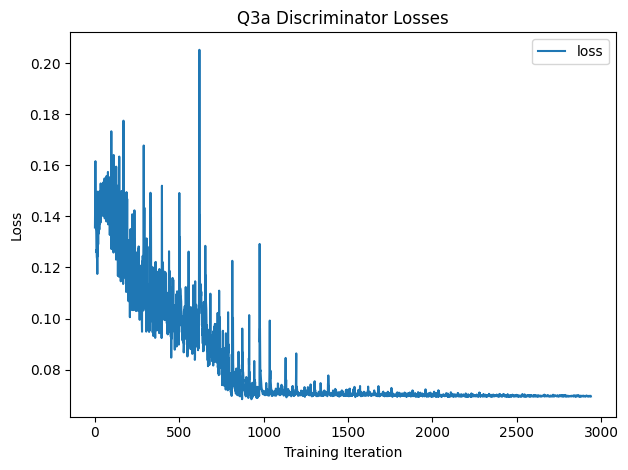

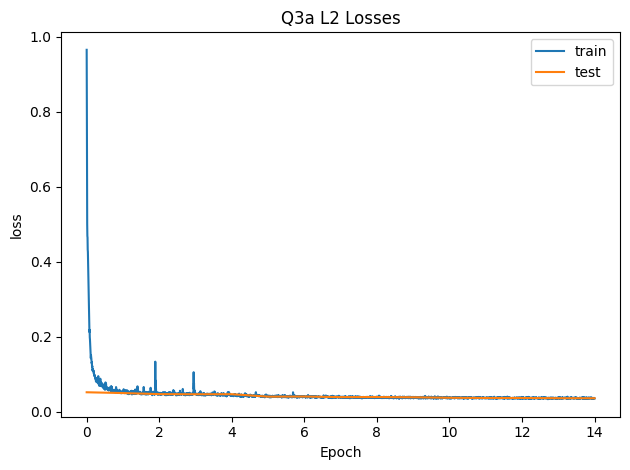

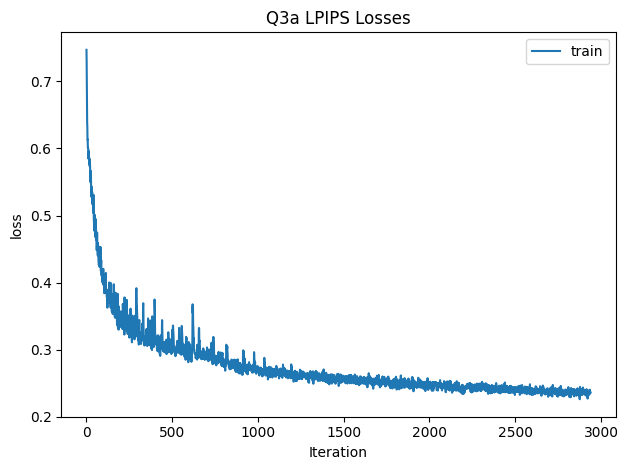

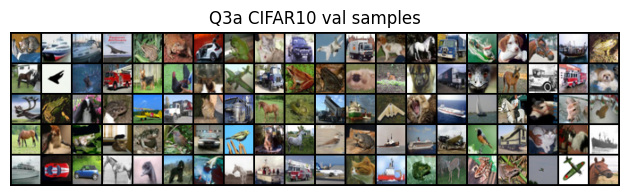

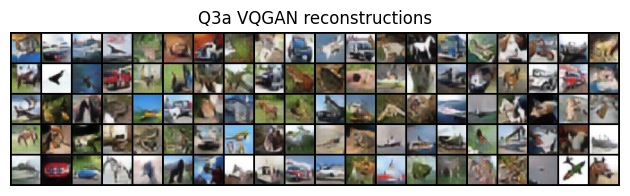

final_val_reconstruction_loss: 0.03634011661633849


In [18]:
q3_save_results(q3a, "a")  # with pips

## Part b: VIT-VQGAN [15]
In this part, you will replace the encoder and decoder in the VQGAN with a Vision Transformer (ViT) following the [Improved VQGAN paper](https://arxiv.org/abs/2110.04627). You may use pre-built ViT modules and/or transformers libraries for the purposes of this exercise. Split images into 4x4 patches which should give you 8x8 patches for each image.

**Discriminator**
In ViT-VQGAN, the patch-based discriminator is replaced with a full StyleGAN discriminator. For the purposes of this exercise, you should use the same discrimiator as described in part a but without splitting into patches. In addition add [spectral normalization](https://pytorch.org/docs/stable/generated/torch.nn.utils.spectral_norm.html#torch-nn-utils-spectral-norm) to all the conv and linear layers and use LeakyReLU instead of ReLU, following [SN-GANs](https://arxiv.org/abs/1802.05957). This is to help with training stability.
```
def Discriminator(*, n_filters=128):
    # all conv layers in the ResBlocks should have spectral normalization
    ResnetBlockDown(3, n_filters=n_filters),
    ResnetBlockDown(128, n_filters=n_filters),
    ResBlock(n_filters, n_filters=n_filters),
    ResBlock(n_filters, n_filters=n_filters),
    nn.LeakyReLU()
    global sum pooling
    nn.Linear(128, 1)
```
* in addition add 

**Loss function**
$L = L_{VQ} + 0.1 L_{GAN} + \alpha L_{perceptual} + L_2 + 0.1 L_1$

The ViT-VQGAN paper introduces a new loss term $L_{Logit\_laplace}$ which is a logit laplace loss. For simplicity, we will use an L1 loss instead.

If you implemented the perceptual loss in the previous part, you can use the same perceptual loss here, otherwise you may keep $\alpha = 0$.


You should be able to largely be able to reuse your implementations in the previous part for this problem
The only 3 updates you need are:
* use ViT for encoder and decoder of VQVAE, use 4 layers, 8 heads, and 256 for the embedding size 
* add L1 loss
* change the discrimiator to look at the full image

**You will provide the following deliverables**
1. Final L2 reconstruction loss
2. Discriminator loss across training
3. $L_{perceptual}$ loss across training
4. Training l2 loss across training
5. Validation l2 reconstruction loss across training, evaluated at the end of every epoch
6. 100 reconstructions of the validation set.


In [8]:
def q3b(train_data, val_data, reconstruct_data):
    """
    train_data: An (n_train, 3, 32, 32) numpy array of CIFAR-10 images with values in [0, 1]
    val_data: An (n_train, 3, 32, 32) numpy array of CIFAR-10 images with values in [0, 1]
    reconstruct_data: An (100, 3, 32, 32) numpy array of CIFAR-10 images with values in [0, 1]. To be used for reconstruction

    Returns
    - a (# of training iterations,) numpy array of the discriminator train losses evaluated every minibatch
    - None or a (# of training iterations,) numpy array of the perceptual train losses evaluated every minibatch
    - a (# of training iterations,) numpy array of the l2 reconstruction evaluated every minibatch
    - a (# of epochs + 1,) numpy array of l2 reconstruction loss evaluated once at initialization and after each epoch on the val_data
    - a (100, 32, 32, 3) numpy array of reconstructions from your model in [0, 1] on the reconstruct_data.
    """
    vqgan = VQGAN(
        train_data,
        val_data,
        reconstruct_data,
        num_epochs=5,
        vit_vqgan=True,
        use_scheduler=False,
        retain_graph=False,
    )
    discriminator_losses, l_pips_losses, l2_recon_train, l2_recon_test = vqgan.train(
        verbose=True, log_freq=10
    )
    reconstructions = vqgan.reconstruct()

    return (
        discriminator_losses,
        l_pips_losses,
        l2_recon_train,
        l2_recon_test,
        reconstructions,
    )

In [9]:
# del vit
# from importlib import reload
# import vit
# vit = reload(vit)

Files already downloaded and verified
Files already downloaded and verified
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth


Batch:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 0, Batch 0:
G loss: 1.8507497310638428, G GAN loss: 0.5389217734336853,G reg loss: 0.6857179403305054, LPIPS loss: 0.7080801129341125, L2 loss: 0.7393792867660522, L1 loss: 0.7161244750022888, G LR: [0.0002]
D loss: 0.13908742368221283, D real loss: 0.4923115670681, D fake loss: 0.8985627293586731, D LR: [0.0002]
Epoch 0, Batch 10:
G loss: 0.8286973834037781, G GAN loss: 0.8046467900276184,G reg loss: 0.011795653961598873, LPIPS loss: 0.6683779954910278, L2 loss: 0.42963308095932007, L1 loss: 0.5307964086532593, G LR: [0.0002]
D loss: 0.11919007450342178, D real loss: 0.5975053906440735, D fake loss: 0.5943952798843384, D LR: [0.0002]
Epoch 0, Batch 20:
G loss: 0.7699428200721741, G GAN loss: 0.5930965542793274,G reg loss: 0.010070806369185448, LPIPS loss: 0.6526946425437927, L2 loss: 0.38354384899139404, L1 loss: 0.4998083710670471, G LR: [0.0002]
D loss: 0.10845337063074112, D real loss: 0.2661159634590149, D fake loss: 0.8184176683425903, D LR: [0.0002]
Epoch 0, Batch 30:
G lo

Batch:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1, Batch 4:
G loss: 0.6290077567100525, G GAN loss: 3.331057071685791,G reg loss: 0.0017049132147803903, LPIPS loss: 0.6371544599533081, L2 loss: 0.2662196755409241, L1 loss: 0.42505940794944763, G LR: [0.0002]
D loss: 0.011516229249536991, D real loss: 0.07704830914735794, D fake loss: 0.03811398148536682, D LR: [0.0002]
Epoch 1, Batch 14:
G loss: 0.6368531584739685, G GAN loss: 3.078495979309082,G reg loss: 0.001370930578559637, LPIPS loss: 0.6226711273193359, L2 loss: 0.28028619289398193, L1 loss: 0.4386046826839447, G LR: [0.0002]
D loss: 0.006059367675334215, D real loss: 0.007015956100076437, D fake loss: 0.053577721118927, D LR: [0.0002]
Epoch 1, Batch 24:
G loss: 0.6421826481819153, G GAN loss: 3.190337657928467,G reg loss: 0.00139338499866426, LPIPS loss: 0.6269475221633911, L2 loss: 0.2829100489616394, L1 loss: 0.44405460357666016, G LR: [0.0002]
D loss: 0.010267135687172413, D real loss: 0.05933200195431709, D fake loss: 0.04333935305476189, D LR: [0.0002]
Epoch 1, Bat

Batch:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 2, Batch 8:
G loss: 0.629706859588623, G GAN loss: 4.533092498779297,G reg loss: 0.0008454268099740148, LPIPS loss: 0.6154272556304932, L2 loss: 0.2779615521430969, L1 loss: 0.4318626821041107, G LR: [0.0002]
D loss: 0.0011803254019469023, D real loss: 0.0008341819047927856, D fake loss: 0.01096907164901495, D LR: [0.0002]
Epoch 2, Batch 18:
G loss: 0.6381499171257019, G GAN loss: 4.575336456298828,G reg loss: 0.0007970891892910004, LPIPS loss: 0.6242672204971313, L2 loss: 0.2815936207771301, L1 loss: 0.43625569343566895, G LR: [0.0002]
D loss: 0.0015157172456383705, D real loss: 0.00347538897767663, D fake loss: 0.011681783013045788, D LR: [0.0002]
Epoch 2, Batch 28:
G loss: 0.6377622485160828, G GAN loss: 5.7441911697387695,G reg loss: 0.0008299948531202972, LPIPS loss: 0.6231285333633423, L2 loss: 0.28199732303619385, L1 loss: 0.43370670080184937, G LR: [0.0002]
D loss: 0.0006659826613031328, D real loss: 0.0025215940549969673, D fake loss: 0.004138232674449682, D LR: [0.0002]

Batch:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 3, Batch 2:
G loss: 0.625965416431427, G GAN loss: 6.663233280181885,G reg loss: 0.00039866374572739005, LPIPS loss: 0.6156893968582153, L2 loss: 0.2746404707431793, L1 loss: 0.43081605434417725, G LR: [0.0002]
D loss: 0.0015906918561086059, D real loss: 0.014628746546804905, D fake loss: 0.0012781714322045445, D LR: [0.0002]
Epoch 3, Batch 12:
G loss: 0.6061224341392517, G GAN loss: 4.563905715942383,G reg loss: 0.0005015417700633407, LPIPS loss: 0.6056621670722961, L2 loss: 0.260445773601532, L1 loss: 0.42344045639038086, G LR: [0.0002]
D loss: 0.0013492080615833402, D real loss: 0.0022717982064932585, D fake loss: 0.011220281943678856, D LR: [0.0002]
Epoch 3, Batch 22:
G loss: 0.614593505859375, G GAN loss: 6.654541015625,G reg loss: 0.0006348820752464235, LPIPS loss: 0.6144578456878662, L2 loss: 0.2641434371471405, L1 loss: 0.4258629083633423, G LR: [0.0002]
D loss: 0.001915937289595604, D real loss: 0.017870347946882248, D fake loss: 0.0012890249490737915, D LR: [0.0002]
Epo

Batch:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 4, Batch 6:
G loss: 0.6267249584197998, G GAN loss: 4.978294372558594,G reg loss: 0.0005585170583799481, LPIPS loss: 0.5977875590324402, L2 loss: 0.28357595205307007, L1 loss: 0.4369668662548065, G LR: [0.0002]
D loss: 0.0011279493337497115, D real loss: 0.004170435015112162, D fake loss: 0.0071090590208768845, D LR: [0.0002]
Epoch 4, Batch 16:
G loss: 0.6205189824104309, G GAN loss: 5.718340873718262,G reg loss: 0.00043370507773943245, LPIPS loss: 0.6018838286399841, L2 loss: 0.27576935291290283, L1 loss: 0.4337398409843445, G LR: [0.0002]
D loss: 0.00042262705392204225, D real loss: 0.0006530718528665602, D fake loss: 0.003573198802769184, D LR: [0.0002]
Epoch 4, Batch 26:
G loss: 0.6108670830726624, G GAN loss: 7.727042198181152,G reg loss: 0.0003591286076698452, LPIPS loss: 0.6052296161651611, L2 loss: 0.26493892073631287, L1 loss: 0.4295423924922943, G LR: [0.0002]
D loss: 0.007708725519478321, D real loss: 0.07664713263511658, D fake loss: 0.00044012110447511077, D LR: [0.0

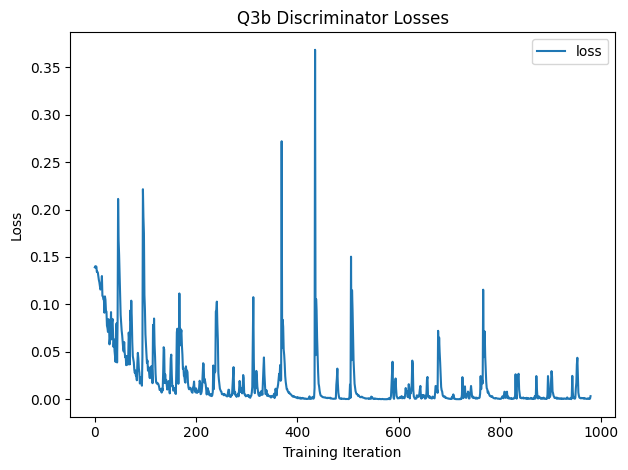

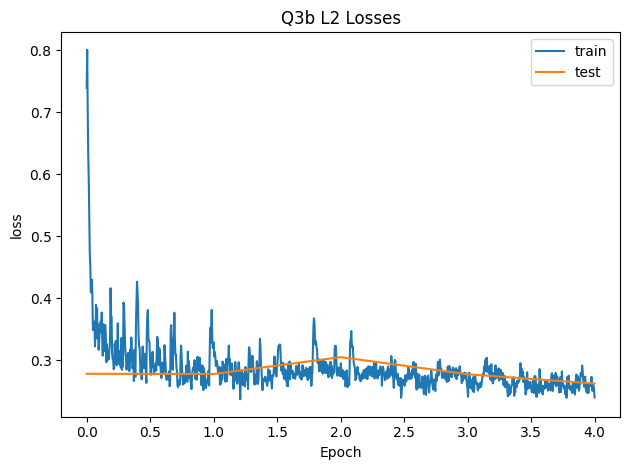

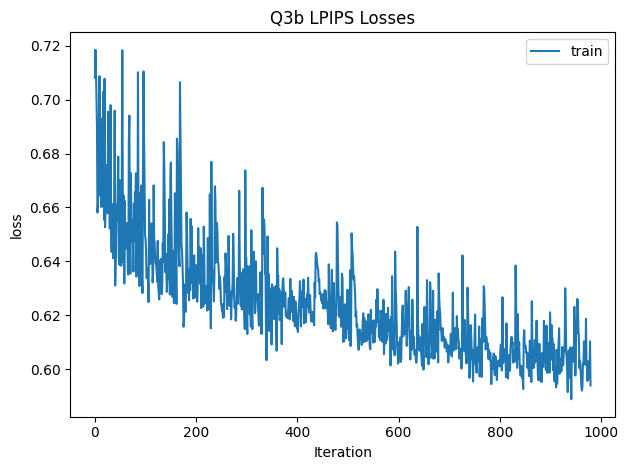

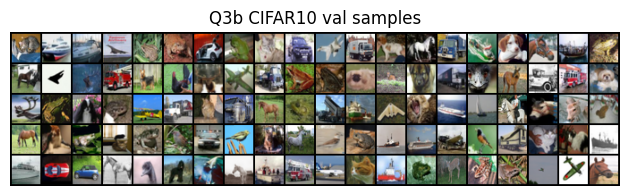

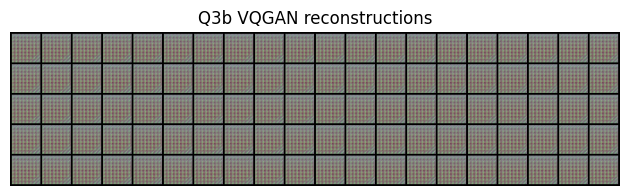

final_val_reconstruction_loss: 0.26198169589042664


In [10]:
q3_save_results(q3b, "b")

# Question 4 (Bonus): CycleGAN [20pt]
In this question, you'll train a CycleGAN model to learn to translate between two different image domains, without any paired data. Execute the following cell to visualize our two datasets: MNIST and Colored MNIST. 

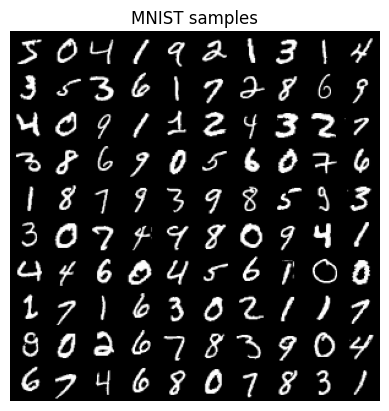

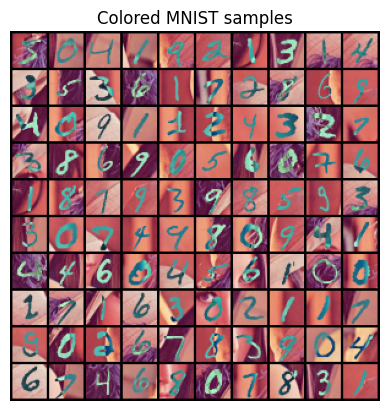

In [3]:
visualize_cyclegan_datasets()

In [CycleGAN](https://arxiv.org/pdf/1703.10593.pdf), the goal is to learn functions $F$ and $G$ that can transform images from $X \rightarrow Y$ and vice-versa. This is an unconstrained problem, so we additionally enforce the *cycle-consistency* property, where we want 
$$x \approx G(F(x))$$
and  
$$y \approx F(G(x))$$
This loss function encourages $F$ and $G$ to approximately invert each other. In addition to this cycle-consistency loss, we also have a standard GAN loss such that $F(x)$ and $G(y)$ look like real images from the other domain. 

Since this is a bonus question, we won't do much hand-holding. We recommend reading through the original paper to get a sense of what architectures and hyperparameters are useful. Note that our datasets are fairly simple, so you won't need excessively large models. 

**You will report the following deliverables**
1. A set of images showing real MNIST digits, transformations of those images into Colored MNIST digits, and reconstructions back into the greyscale domain. 
2. A set of images showing real Colored MNIST digits, transformations of those images, and reconstructions. 

## Solution

In [36]:
import torchvision
import os
import pickle
import scipy.io
import numpy as np

from torch.autograd import Variable


class MNISTDataset(data.Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        image = self.data[index]

        if self.transform:
            image = self.transform(image)

        return image


def deconv(c_in, c_out, k_size, stride=2, pad=1, bn=True):
    """Custom deconvolutional layer for simplicity."""
    layers = []
    layers.append(nn.ConvTranspose2d(c_in, c_out, k_size, stride, pad, bias=False))
    if bn:
        # TODO: this is equivalent to instance normalization for batch size 1,
        # but convert it to nn.InstanceNorm2d just in case.
        layers.append(nn.BatchNorm2d(c_out))
    return nn.Sequential(*layers)


def conv(c_in, c_out, k_size, stride=2, pad=1, bn=True):
    """Custom convolutional layer for simplicity."""
    layers = []
    layers.append(nn.Conv2d(c_in, c_out, k_size, stride, pad, bias=False))
    if bn:
        # TODO: this is equivalent to instance normalization for batch size 1,
        # but convert it to nn.InstanceNorm2d just in case.
        layers.append(nn.BatchNorm2d(c_out))
    return nn.Sequential(*layers)


class G12(nn.Module):
    """Generator for transfering from cmnist to mnist"""

    def __init__(self, conv_dim=64):
        super(G12, self).__init__()
        # encoding blocks
        self.conv1 = conv(3, conv_dim, 4)
        self.conv2 = conv(conv_dim, conv_dim * 2, 4)

        # residual blocks
        self.conv3 = conv(conv_dim * 2, conv_dim * 2, 3, 1, 1)
        self.conv4 = conv(conv_dim * 2, conv_dim * 2, 3, 1, 1)

        # decoding blocks
        self.deconv1 = deconv(conv_dim * 2, conv_dim, 4)
        self.deconv2 = deconv(conv_dim, 1, 4, bn=False)

    def forward(self, x):
        # print("G12 x.shape:", x.shape)  # (?, 3, 28, 28)
        out = F.leaky_relu(self.conv1(x), 0.05)  # (?, 64, 14, 14)
        # print("G12 out.shape:", out.shape)
        out = F.leaky_relu(self.conv2(out), 0.05)  # (?, 128, 7, 7)
        # print("G12 out.shape:", out.shape)

        out = F.leaky_relu(self.conv3(out), 0.05)  # ( " )
        # print("G12 out.shape:", out.shape)
        out = F.leaky_relu(self.conv4(out), 0.05)  # ( " )
        # print("G12 out.shape:", out.shape)

        out = F.leaky_relu(self.deconv1(out), 0.05)  # (?, 64, 14, 14)
        # print("G12 out.shape:", out.shape)
        out = F.tanh(self.deconv2(out))  # (?, 3, 28, 28)
        # print("G12 out.shape:", out.shape)
        return out


class G21(nn.Module):
    """Generator for transfering from mnist to cmnist"""

    def __init__(self, conv_dim=64):
        super(G21, self).__init__()
        # encoding blocks
        self.conv1 = conv(1, conv_dim, 4)
        self.conv2 = conv(conv_dim, conv_dim * 2, 4)

        # residual blocks
        self.conv3 = conv(conv_dim * 2, conv_dim * 2, 3, 1, 1)
        self.conv4 = conv(conv_dim * 2, conv_dim * 2, 3, 1, 1)

        # decoding blocks
        self.deconv1 = deconv(conv_dim * 2, conv_dim, 4)
        self.deconv2 = deconv(conv_dim, 3, 4, bn=False)

    def forward(self, x):
        # print("G21 x.shape:", x.shape)  # (?, 1, 28, 28)
        out = F.leaky_relu(self.conv1(x), 0.05)  # (?, 64, 14, 14)
        # print("G21 out.shape:", out.shape)
        out = F.leaky_relu(self.conv2(out), 0.05)  # (?, 128, 7, 7)
        # print("G21 out.shape:", out.shape)

        out = F.leaky_relu(self.conv3(out), 0.05)  # ( " )
        # print("G21 out.shape:", out.shape)
        out = F.leaky_relu(self.conv4(out), 0.05)  # ( " )
        # print("G21 out.shape:", out.shape)

        out = F.leaky_relu(self.deconv1(out), 0.05)  # (?, 64, 14, 14)
        # print("G21 out.shape:", out.shape)
        out = F.tanh(self.deconv2(out))  # (?, 3, 28, 28)
        # print("G21 out.shape:", out.shape)
        return out


class D1(nn.Module):
    """Discriminator for cmnist."""

    def __init__(self, conv_dim=64, k_size=3, use_labels=False):
        super(D1, self).__init__()
        self.conv1 = conv(3, conv_dim, k_size, bn=False)
        self.conv2 = conv(conv_dim, conv_dim * 2, k_size)
        self.conv3 = conv(conv_dim * 2, conv_dim * 4, k_size)
        n_out = 11 if use_labels else 1
        self.fc = conv(conv_dim * 4, n_out, k_size, 1, 0, False)

    def forward(self, x):
        # print(x.shape)  # (?, 3, 28, 28)
        out = F.leaky_relu(self.conv1(x), 0.05)  # (?, 64, 14, 14)
        out = F.leaky_relu(self.conv2(out), 0.05)  # (?, 128, 7, 7)
        out = F.leaky_relu(self.conv3(out), 0.05)  # (?, 256, 4, 4)
        out = self.fc(out).squeeze()
        return torch.sigmoid(out)


class D2(nn.Module):
    """Discriminator for mnist."""

    def __init__(self, conv_dim=64, k_size=3, use_labels=False):
        super(D2, self).__init__()
        self.conv1 = conv(1, conv_dim, k_size, bn=False)
        self.conv2 = conv(conv_dim, conv_dim * 2, k_size)
        self.conv3 = conv(conv_dim * 2, conv_dim * 4, k_size)
        n_out = 11 if use_labels else 1
        self.fc = conv(conv_dim * 4, n_out, k_size, 1, 0, False)

    def forward(self, x):
        # print(x.shape)  # (?, 1, 28, 28)
        out = F.leaky_relu(self.conv1(x), 0.05)  # (?, 64, 14, 14)
        out = F.leaky_relu(self.conv2(out), 0.05)  # (?, 128, 7, 7)
        out = F.leaky_relu(self.conv3(out), 0.05)  # (?, 256, 4, 4)
        out = self.fc(out).squeeze()
        return torch.sigmoid(out)  # (2, 2)


def normalize_img(img):
    return (img * 2) - 1


def unnormalize_img(img):
    return (img + 1) / 2


class CycleGANSolver(object):
    def __init__(
        self,
        mnist_data,
        cmnist_data,
        g_conv_dim: int = 64,
        d_conv_dim: int = 64,
        train_iters: int = 40_000,
        lr: float = 0.0002,
        beta1: float = 0.5,
        beta2: float = 0.999,
        log_step: int = 10,
        num_samples: int = 20,
        model_path: str = "cyclegan_models/",
    ):
        self.beta1 = beta1
        self.beta2 = beta2

        self.g_conv_dim = g_conv_dim
        self.d_conv_dim = d_conv_dim
        self.train_iters = train_iters
        self.lr = lr
        self.log_step = log_step
        self.model_path = model_path

        self.mnist_loader, self.cmnist_loader = self.get_loaders(
            mnist_data, cmnist_data
        )
        self.sample_mnist_loader, self.sample_cmnist_loader = self.get_loaders(
            mnist_data[:num_samples], cmnist_data[:num_samples]
        )
        self.build_model()

    def get_loaders(self, mnist_data, cmnist_data):
        """Creates the data loaders for the mnist and cmnist datasets."""
        # mnist has 1 channel and cmnist has 3 channels
        # mnist_transform = transforms.Compose(
        #     [
        #         transforms.Normalize((0.5,), (0.5,)),
        #     ]
        # )
        # cmnist_transform = transforms.Compose(
        #     [
        #         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        #     ]
        # )

        # mnist_dataset = MNISTDataset(
        #     torch.tensor(mnist_data).float(), transform=mnist_transform
        # )
        # cmnist_dataset = MNISTDataset(
        #     torch.tensor(cmnist_data).float(), transform=cmnist_transform
        # )

        assert mnist_data.min() >= 0 and mnist_data.max() <= 1
        # Normalize to [-1, 1].
        mnist_data = normalize_img(mnist_data)
        assert mnist_data.min() >= -1 and mnist_data.max() <= 1

        assert cmnist_data.min() >= 0 and cmnist_data.max() <= 1
        # Normalize to [-1, 1].
        cmnist_data = normalize_img(cmnist_data)
        assert cmnist_data.min() >= -1 and cmnist_data.max() <= 1

        mnist_dataset = data.TensorDataset(torch.tensor(mnist_data).float())
        cmnist_dataset = data.TensorDataset(torch.tensor(cmnist_data).float())

        mnist_loader = data.DataLoader(
            dataset=mnist_dataset,
            batch_size=1,
            shuffle=True,
        )
        cmnist_loader = data.DataLoader(
            dataset=cmnist_dataset,
            batch_size=1,
            shuffle=True,
        )

        return mnist_loader, cmnist_loader

    def build_model(self):
        """Builds a generator and a discriminator."""
        self.g12 = G12(conv_dim=self.g_conv_dim).to(ptu.device)
        self.g21 = G21(conv_dim=self.g_conv_dim).to(ptu.device)
        self.d1 = D1(conv_dim=self.d_conv_dim, use_labels=False).to(ptu.device)
        self.d2 = D2(conv_dim=self.d_conv_dim, use_labels=False).to(ptu.device)

        g_params = list(self.g12.parameters()) + list(self.g21.parameters())
        d_params = list(self.d1.parameters()) + list(self.d2.parameters())

        self.g_optimizer = optim.Adam(g_params, self.lr, [self.beta1, self.beta2])
        self.d_optimizer = optim.Adam(d_params, self.lr, [self.beta1, self.beta2])

    # TODO: delete?
    def merge_images(self, sources, targets, k=10):
        _, _, h, w = sources.shape
        row = int(np.sqrt(self.batch_size))
        merged = np.zeros([3, row * h, row * w * 2])
        for idx, (s, t) in enumerate(zip(sources, targets)):
            i = idx // row
            j = idx % row
            merged[:, i * h : (i + 1) * h, (j * 2) * h : (j * 2 + 1) * h] = s
            merged[:, i * h : (i + 1) * h, (j * 2 + 1) * h : (j * 2 + 2) * h] = t
        return merged.transpose(1, 2, 0)

    def to_var(self, x):
        """Converts numpy to variable."""
        return ptu.tensor(x, requires_grad=True)

    def to_data(self, x):
        """Converts variable to numpy."""
        return x.cpu().data.numpy()

    def reset_grad(self):
        """Zeros the gradient buffers."""
        self.g_optimizer.zero_grad()
        self.d_optimizer.zero_grad()

    def train(self):
        mnist_iter = iter(self.mnist_loader)
        cmnist_iter = iter(self.cmnist_loader)
        iter_per_epoch = min(len(mnist_iter), len(cmnist_iter))

        # fixed mnist and cmnist for sampling
        fixed_mnist = self.to_var(next(mnist_iter)[0])
        fixed_cmnist = self.to_var(next(cmnist_iter)[0])

        for step in range(self.train_iters + 1):
            # reset data_iter for each epoch
            if (step + 1) % iter_per_epoch == 0:
                mnist_iter = iter(self.mnist_loader)
                cmnist_iter = iter(self.cmnist_loader)

            # load svhn and mnist dataset
            mnist = ptu.tensor(next(mnist_iter)[0])
            cmnist = ptu.tensor(next(cmnist_iter)[0])
            # svhn, s_labels = mnist_iter.next()
            # svhn, s_labels = self.to_var(svhn), self.to_var(s_labels).long().squeeze()
            # mnist, m_labels = cmnist_iter.next()
            # mnist, m_labels = self.to_var(mnist), self.to_var(m_labels)

            # ============ train D ============#

            # train with real images
            self.reset_grad()
            # print("cmnist.shape:", cmnist.shape)
            d1_cmnist_pred = self.d1(cmnist)
            # print("d1_cmnist_pred.shape:", d1_cmnist_pred.shape)
            d1_loss = torch.mean((d1_cmnist_pred - 1) ** 2)

            d2_mnist_pred = self.d2(mnist)
            d2_loss = torch.mean((d2_mnist_pred - 1) ** 2)

            d_cmnist_loss = d1_loss
            d_mnist_loss = d2_loss
            d_real_loss = d1_loss + d2_loss
            d_real_loss.backward()
            self.d_optimizer.step()

            # train with fake images
            self.reset_grad()
            fake_mnist = self.g12(cmnist)
            d2_fake_mnist_pred = self.d2(fake_mnist)
            d2_loss = torch.mean(d2_fake_mnist_pred**2)

            fake_cmnist = self.g21(mnist)
            d1_fake_cmnist_pred = self.d1(fake_cmnist)
            d1_loss = torch.mean(d1_fake_cmnist_pred**2)

            d_fake_loss = d1_loss + d2_loss
            d_fake_loss.backward()
            self.d_optimizer.step()

            # ============ train G ============#

            # train cmnist-mnist-cmnist cycle
            self.reset_grad()
            fake_mnist = self.g12(cmnist)
            d2_fake_mnist_pred = self.d2(fake_mnist)
            recon_cmnist = self.g21(fake_mnist)
            # GAN loss
            backward_gan_loss = torch.mean((d2_fake_mnist_pred - 1) ** 2)
            # Reconstruction loss
            backward_recon_loss = torch.mean((cmnist - recon_cmnist) ** 2)
            backward_g_loss = backward_gan_loss + backward_recon_loss
            backward_g_loss.backward()
            self.g_optimizer.step()

            # train mnist-cmnist-mnist cycle
            self.reset_grad()
            fake_cmnist = self.g21(mnist)
            d1_fake_cmnist_pred = self.d1(fake_cmnist)
            recon_mnist = self.g12(fake_cmnist)
            forward_gan_loss = torch.mean((d1_fake_cmnist_pred - 1) ** 2)
            forward_recon_loss = torch.mean((mnist - recon_mnist) ** 2)
            forward_g_loss = forward_gan_loss + forward_recon_loss
            forward_g_loss.backward()
            self.g_optimizer.step()

            # print the log info
            if (step + 1) % self.log_step == 0:
                print("Step [%d/%d]" % (step + 1, self.train_iters))
                print(
                    "forward_g_loss: %.4f, forward_gan_loss: %.4f, forward_recon_loss: %.4f"
                    % (
                        forward_g_loss.item(),
                        forward_gan_loss.item(),
                        forward_recon_loss.item(),
                    )
                )
                print(
                    "backward_g_loss: %.4f, backward_gan_loss: %.4f, backward_recon_loss: %.4f"
                    % (
                        backward_g_loss.item(),
                        backward_gan_loss.item(),
                        backward_recon_loss.item(),
                    )
                )
                print(
                    "d_real_loss: %.4f, d_cmnist_loss: %.4f, d_mnist_loss: %.4f, "
                    "d_fake_loss: %.4f"
                    % (
                        d_real_loss.item(),
                        d_cmnist_loss.item(),
                        d_mnist_loss.item(),
                        d_fake_loss.item(),
                    )
                )
                print()

            # save the sampled images

    def sample(self):
        mnist_samples = []
        fake_cmnist_samples = []
        mnist_recon_samples = []
        for (mnist,) in self.sample_mnist_loader:
            mnist = mnist.to(ptu.device)
            fake_cmnist = self.g21(mnist)
            mnist_recon = self.g12(fake_cmnist)
            mnist_samples.append(unnormalize_img(mnist.detach().cpu().numpy()))
            fake_cmnist_samples.append(
                unnormalize_img(fake_cmnist.detach().cpu().numpy())
            )
            mnist_recon_samples.append(
                unnormalize_img(mnist_recon.detach().cpu().numpy())
            )

        cmnist_samples = []
        fake_mnist_samples = []
        cmnist_recon_samples = []
        for (cmnist,) in self.sample_cmnist_loader:
            cmnist = cmnist.to(ptu.device)
            fake_mnist = self.g12(cmnist)
            cmnist_recon = self.g21(fake_mnist)
            cmnist_samples.append(unnormalize_img(cmnist.detach().cpu().numpy()))
            fake_mnist_samples.append(
                unnormalize_img(fake_mnist.detach().cpu().numpy())
            )
            cmnist_recon_samples.append(
                unnormalize_img(cmnist_recon.detach().cpu().numpy())
            )

        mnist_samples = np.concatenate(mnist_samples, axis=0).transpose(0, 2, 3, 1)
        fake_cmnist_samples = np.concatenate(fake_cmnist_samples, axis=0).transpose(
            0, 2, 3, 1
        )
        mnist_recon_samples = np.concatenate(mnist_recon_samples, axis=0).transpose(
            0, 2, 3, 1
        )
        cmnist_samples = np.concatenate(cmnist_samples, axis=0).transpose(0, 2, 3, 1)
        fake_mnist_samples = np.concatenate(fake_mnist_samples, axis=0).transpose(
            0, 2, 3, 1
        )
        cmnist_recon_samples = np.concatenate(cmnist_recon_samples, axis=0).transpose(
            0, 2, 3, 1
        )

        return (
            mnist_samples,
            fake_cmnist_samples,
            mnist_recon_samples,
            cmnist_samples,
            fake_mnist_samples,
            cmnist_recon_samples,
        )

    # if (step + 1) % 5000 == 0:
    #     # save the model parameters for each epoch
    #     g12_path = os.path.join(self.model_path, "g12-%d.pkl" % (step + 1))
    #     g21_path = os.path.join(self.model_path, "g21-%d.pkl" % (step + 1))
    #     d1_path = os.path.join(self.model_path, "d1-%d.pkl" % (step + 1))
    #     d2_path = os.path.join(self.model_path, "d2-%d.pkl" % (step + 1))
    #     torch.save(self.g12.state_dict(), g12_path)
    #     torch.save(self.g21.state_dict(), g21_path)
    #     torch.save(self.d1.state_dict(), d1_path)
    #     torch.save(self.d2.state_dict(), d2_path)

In [46]:
def q4(mnist_data, cmnist_data):
    """
    mnist_data: An (60000, 1, 28, 28) numpy array of black and white images with values in [0, 1]
    cmnist_data: An (60000, 3, 28, 28) numpy array of colored images with values in [0, 1]

    Returns
    - a (20, 28, 28, 1) numpy array of real MNIST digits, in [0, 1]
    - a (20, 28, 28, 3) numpy array of translated Colored MNIST digits, in [0, 1]
    - a (20, 28, 28, 1) numpy array of reconstructed MNIST digits, in [0, 1]

    - a (20, 28, 28, 3) numpy array of real Colored MNIST digits, in [0, 1]
    - a (20, 28, 28, 1) numpy array of translated MNIST digits, in [0, 1]
    - a (20, 28, 28, 3) numpy array of reconstructed Colored MNIST digits, in [0, 1]
    """
    num_epochs = 5
    solver = CycleGANSolver(
        mnist_data, cmnist_data, train_iters=num_epochs * len(mnist_data), log_step=1000
    )
    solver.train()
    return solver.sample()

## Results

In [47]:
q4_save_results(q4)

Step [1000/300000]
forward_g_loss: 0.8888, forward_gan_loss: 0.8129, forward_recon_loss: 0.0759
backward_g_loss: 0.3903, backward_gan_loss: 0.2786, backward_recon_loss: 0.1117
d_real_loss: 0.5230, d_cmnist_loss: 0.2932, d_mnist_loss: 0.2298, d_fake_loss: 0.3512

Step [2000/300000]
forward_g_loss: 0.7914, forward_gan_loss: 0.7627, forward_recon_loss: 0.0288
backward_g_loss: 0.4037, backward_gan_loss: 0.2641, backward_recon_loss: 0.1396
d_real_loss: 0.2823, d_cmnist_loss: 0.1031, d_mnist_loss: 0.1792, d_fake_loss: 0.2990

Step [3000/300000]
forward_g_loss: 0.9392, forward_gan_loss: 0.8325, forward_recon_loss: 0.1066
backward_g_loss: 0.5189, backward_gan_loss: 0.2547, backward_recon_loss: 0.2641
d_real_loss: 0.2351, d_cmnist_loss: 0.0003, d_mnist_loss: 0.2348, d_fake_loss: 0.3022

Step [4000/300000]
forward_g_loss: 1.0313, forward_gan_loss: 0.9350, forward_recon_loss: 0.0963
backward_g_loss: 0.6025, backward_gan_loss: 0.3139, backward_recon_loss: 0.2885
d_real_loss: 0.2700, d_cmnist_loss:

KeyboardInterrupt: 

In [5]:
mnist_data, cmnist_data = load_q4_data()

In [39]:
solver = CycleGANSolver(mnist_data, cmnist_data, train_iters=100, log_step=10)
solver.train()

Step [10/100]
forward_g_loss: 1.5158, forward_gan_loss: 0.6116, forward_recon_loss: 0.9042
backward_g_loss: 1.0875, backward_gan_loss: 0.6200, backward_recon_loss: 0.4674
d_real_loss: 0.2356, d_cmnist_loss: 0.1312, d_mnist_loss: 0.1044, d_fake_loss: 0.3360

Step [20/100]
forward_g_loss: 1.2497, forward_gan_loss: 0.5985, forward_recon_loss: 0.6512
backward_g_loss: 1.1980, backward_gan_loss: 0.7233, backward_recon_loss: 0.4747
d_real_loss: 0.1660, d_cmnist_loss: 0.1102, d_mnist_loss: 0.0558, d_fake_loss: 0.3316

Step [30/100]
forward_g_loss: 0.9762, forward_gan_loss: 0.6125, forward_recon_loss: 0.3637
backward_g_loss: 1.2174, backward_gan_loss: 0.7693, backward_recon_loss: 0.4480
d_real_loss: 0.2466, d_cmnist_loss: 0.2158, d_mnist_loss: 0.0308, d_fake_loss: 0.2857

Step [40/100]
forward_g_loss: 1.0542, forward_gan_loss: 0.7078, forward_recon_loss: 0.3463
backward_g_loss: 1.1780, backward_gan_loss: 0.7746, backward_recon_loss: 0.4034
d_real_loss: 0.0805, d_cmnist_loss: 0.0521, d_mnist_los

In [40]:
(
    mnist_samples,
    fake_cmnist_samples,
    mnist_recon_samples,
    cmnist_samples,
    fake_mnist_samples,
    cmnist_recon_samples,
) = solver.sample()